In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dane

## Hexagon

In [2]:
dfhex = pd.read_csv("LAB2_DANE/hexagon.csv")
xhex = np.array(dfhex["x"])
yhex = np.array(dfhex["y"])
xyhex = np.vstack((xhex, yhex)).T
chex = np.array(dfhex["c"])

In [3]:
xyhex

array([[ 2.40204702,  3.72869525],
       [-0.66003215,  7.04720564],
       [ 2.20283931, -2.39430285],
       ...,
       [-3.01448899, -2.82425731],
       [ 3.7463463 ,  3.00187626],
       [-0.43485983, -5.91133972]])

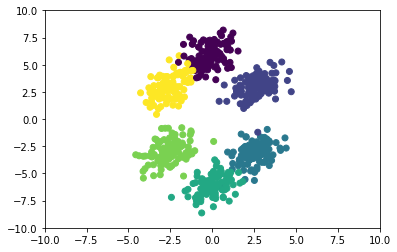

In [4]:
plt.scatter(
    dfhex["x"],
    dfhex["y"],
    c=dfhex["c"]
)
plt.ylim((-10, 10))
plt.xlim((-10, 10))
plt.show()

Zbiór tak wygląda. Do ewaluacji podzielę go wedłgu klastrów.

In [5]:
split = {
    category: np.array(
        dfhex[dfhex["c"] == category][["x", "y"]]
    )
    for category in dfhex["c"].unique()
}

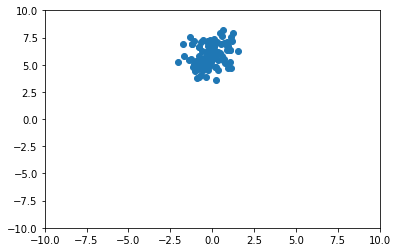

In [228]:
plt.scatter(
    split[0][:, 0],
    split[0][:, 1]
)
plt.ylim((-10, 10))
plt.xlim((-10, 10))
plt.show()
plt.show()

Pandas jak zwykle jest bardzo toporny, ale udało się.

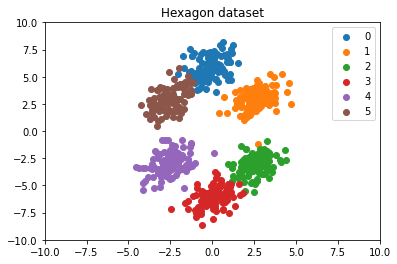

In [32]:
for cluster, data in sorted(split.items()):
    plt.scatter(
        data[:, 0],
        data[:, 1],
        c="C"+str(cluster),
        label=str(cluster)
    )
plt.ylim((-10, 10))
plt.xlim((-10, 10))
plt.legend()
plt.title("Hexagon dataset")
plt.show()

Jest możliwe, że algorytm będzie miał problemy z rozdzieleniem klastrów (0, 5) i (2, 3). Jeżeli tak faktycznie będzie to nie będę drążył tematu głębiej.

## Cube

In [55]:
dfcub = pd.read_csv("LAB2_DANE/cube.csv")
xcub = np.array(dfcub["x"])
ycub = np.array(dfcub["y"])
zcub = np.array(dfcub["z"])
data_cub = np.vstack((xcub, ycub, zcub)).T
ccub = np.array(dfcub["c"])

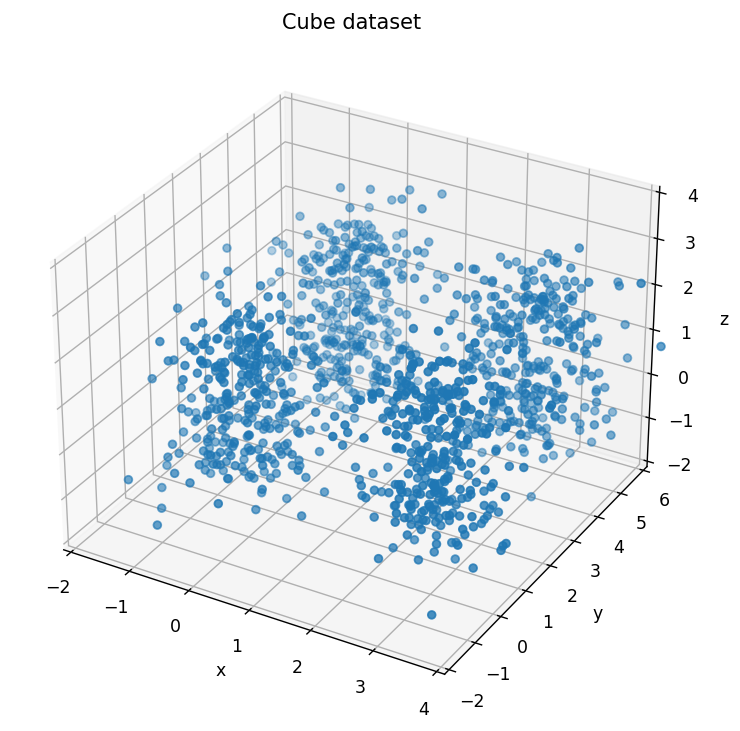

In [72]:
fig = plt.figure(figsize=(7,10), dpi=125)
ax = plt.axes(projection ='3d')
ax.scatter3D(xcub, ycub, zcub)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_xlim(-2, 4)
ax.set_ylim(-2, 6)
ax.set_zlim(-2, 4)
ax.set_title("Cube dataset")
plt.show()

In [62]:
split_cub = {
    category: np.array(
        dfcub[dfcub["c"] == category][["x", "y", "z"]]
    )
    for category in dfcub["c"].unique()
}

Podział dokładnie taki sam jak w przypadku sześciokąta.

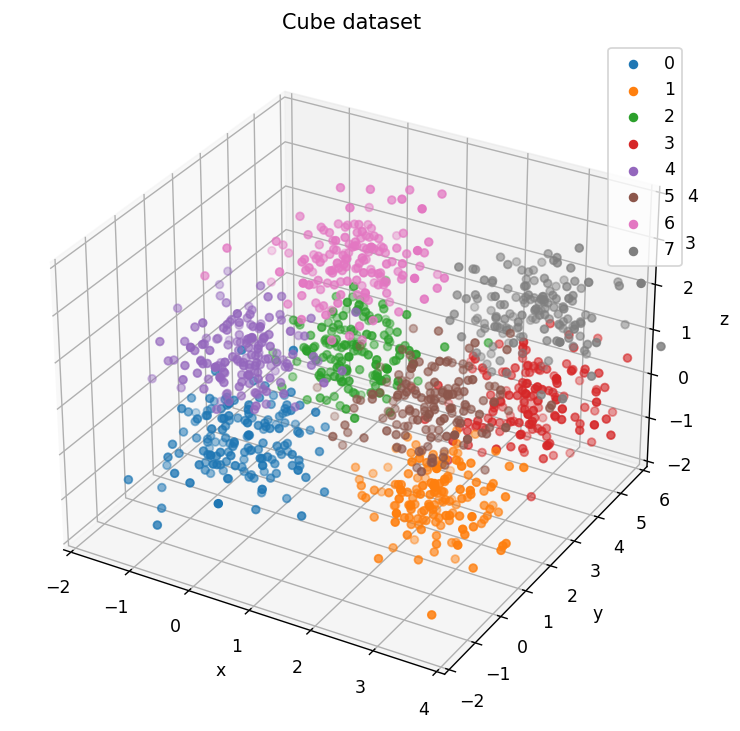

In [78]:
fig = plt.figure(figsize=(7,10), dpi=125)
ax = plt.axes(projection ='3d')
for cluster, data in sorted(split_cub.items()):
    ax.scatter3D(
        data[:, 0],
        data[:, 1],
        data[:, 2],
        c="C"+str(cluster),
        label=str(cluster)
    )
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_xlim(-2, 4)
ax.set_ylim(-2, 6)
ax.set_zlim(-2, 4)
ax.legend()
plt.title("Cube dataset")
plt.show()

Problem może być taki sam, klastry rozdzielone na osi $z$ mogą się zlewać.

# Sieć Kohonena
## Kod

In [93]:
def distance_euclidean(x, y):
    return np.sqrt(np.sum((x - y)**2))

def gauss_factory(metric):
    def gauss(n1, n2, t):
        d = metric(np.array(n1), np.array(n2))
        return np.exp(-d ** 2)
    return gauss

def mexican_factory(metric):
    def mexican(n1, n2, t):
        dt = t * metric(np.array(n1), np.array(n2))
        exp_part = np.exp(- dt**2)
        mult_part = (2 - 4 * dt**2)
        return mult_part * exp_part
    return mexican

def mexican_factory_no_t(metric):
    def mexican(n1, n2, t):
        d = metric(np.array(n1), np.array(n2))
        exp_part = np.exp(- d**2)
        mult_part = (2 - 4 * d**2)
        return mult_part * exp_part
    return mexican


def exp_slowdown_factory(rate):
    def slowdown(t):
        return np.exp(-t/rate)
    return slowdown

def pow_slowdown_factory(rate):
    def slowdown(t):
        return rate ** t
    return slowdown

def const_slowdown_factory(rate):
    def slowdown(t):
        return rate
    return slowdown


In [85]:
class KOH:
    def __init__(self,
                 data,
                 output_shape,
                 /,
                 metric = distance_euclidean,
                 neighborhood = gauss_factory(distance_euclidean),
                 slowdown_function = exp_slowdown_factory(0.1), #alpha
                 evaluation_data = None, # split
                ):
        self.data = data.copy()
        self.input_shape = data.shape[1]
        self.output_shape = output_shape
        self.weights = np.random.random(
            (self.input_shape,) + self.output_shape
        )
        self.metric = metric
        self.neighborhood = neighborhood
        self.slowdown_function = slowdown_function
        self.evaluation_data = evaluation_data
        
    def train(self, num_epoch):
        for t in range(num_epoch):
            print(f"Epoch: {t+1: <10}", end="\r")
            
            np.random.shuffle(self.data)
            for obs in self.data:    
                # argmin
                ijstar = min([
                    (self.metric(self.weights[:, i, j], obs), (i,j))
                    for i in range(self.output_shape[0])
                    for j in range(self.output_shape[1])
                ])[1]
                
                # update weights
                for i in range(self.output_shape[0]):
                    for j in range(self.output_shape[1]):
                        distance = self.neighborhood((i,j), ijstar, t) 
                        a = self.slowdown_function(t)
                        diff = (obs - self.weights[:, i, j])
                        self.weights[:, i, j] += distance * a * diff
                        
    def apply(self, obs):
        return [self.weights[i, :, :] * el for i, el in enumerate(obs)]
    
    def plot_evaluate(self, nrow=2, ncol=3):
        classes = sorted(self.evaluation_data.keys())
        fig, axs = plt.subplots(nrow, ncol, figsize=(10, 7))
        rowcol_generator = ((r,c) for r in range(nrow) for c in range(ncol))
        for cur_class, (row, col) in zip(classes, rowcol_generator):
            axs[row,col].imshow(
                np.sum([
                    np.sum(
                        self.apply(obs),
                        axis=0
                    ) 
                    for obs in self.evaluation_data[cur_class] 
                    ],
                    axis=0
                )
            )
            axs[row, col].set_title(f"Cluster {cur_class}")
        return fig, axs
            
    def get_neuron_coordinates(self):
        neuron_count = self.output_shape[0] * self.output_shape[1]
        return self.weights.T.reshape(neuron_count, self.input_shape)
    
    def plot_neurons_2d(self):
        neuron_coords = self.get_neuron_coordinates()
        fig, ax = plt.subplots(figsize=(5, 3.5), dpi=125)
        ax.scatter(
            neuron_coords[:, 0],
            neuron_coords[:, 1]
        )
        return fig, ax
    
    def classify(self, input_data):
        return np.array([
            np.argmin([
                self.metric(neuron, obs)
                for neuron in self.get_neuron_coordinates()
            ])
            for obs in input_data
        ])
    
    def v_measure(self, input_data, actual):
        from sklearn.metrics import v_measure_score
        
        return v_measure_score(
            self.classify(input_data), 
            actual
        )

## Diagnostyka działania

In [191]:
koh1 = KOH(xyhex, (10,10), slowdown_function=exp_slowdown_factory(1.0), evaluation_data=split)
koh1.train(20)

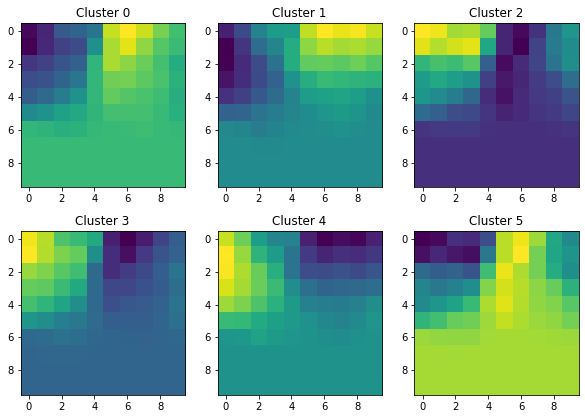

In [192]:
koh1.plot_evaluate()

Gaussowska funkcja sąsiedztwa działa nieźle, można wyłuskać zazwyczaj 2 klastry łączące po 3 faktyczne skupienia: 
* (0, 1, 5) 
* (1, 2, 3)

In [193]:
koh2 = KOH(
    xyhex, 
    (10,10),
    neighborhood=mexican_factory(distance_euclidean),
    slowdown_function=exp_slowdown_factory(1.0),
    evaluation_data=split)
koh2.train(20)

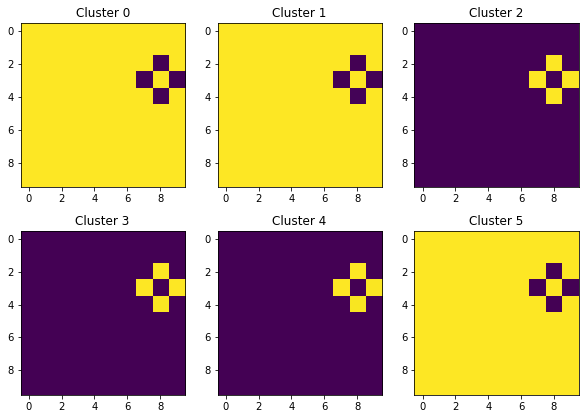

In [194]:
koh2.plot_evaluate()

Niestety z kapeluszem meksykańskim jest trochę więcej problemów. Wszystko sprowadza się do jednego punktu. Skorzystałem z funkcji sąsiedztwa parametryzowanej po $t$, a na slajdach jest bez $t$. Spróbuję z drugą wersją.

In [195]:
koh3 = KOH(
    xyhex, 
    (10,10),
    neighborhood=mexican_factory(distance_euclidean),
    slowdown_function=exp_slowdown_factory(0.1),
    evaluation_data=split)
koh3.train(20)

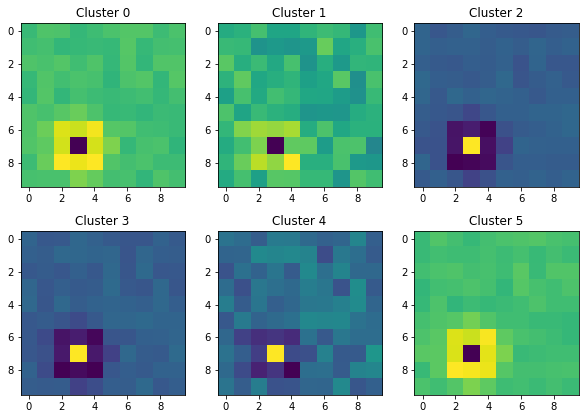

In [196]:
koh3.plot_evaluate()

Widać lepiej kapelusz, ale nadal jest źle. Być może za mało czasu?

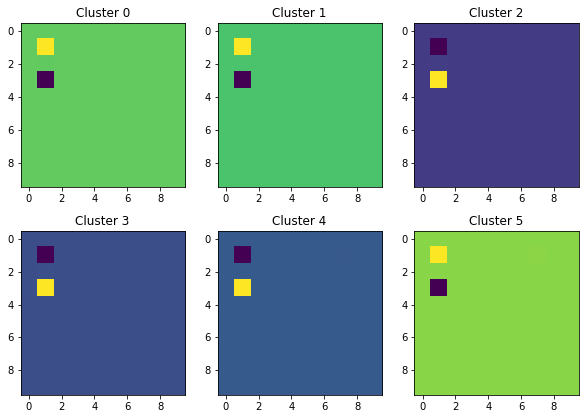

In [201]:
koh4 = KOH(
    xyhex, 
    (10,10),
    neighborhood=mexican_factory_no_t(distance_euclidean),
    slowdown_function=exp_slowdown_factory(0.1),
    evaluation_data=split)
koh4.train(50)
koh4.plot_evaluate()

Jescze gorzej, ale udało mi się znaleźć błąd. Zapomniałem odwrócić znaku funkcji.

In [112]:
def mexican_factory(metric):
    def mexican(n1, n2, t):
        dt = t * metric(np.array(n1), np.array(n2))
        exp_part = np.exp(- dt**2)
        mult_part = (2 - 4 * dt**2)
        return - mult_part * exp_part
    return mexican

def mexican_factory_no_t(metric):
    def mexican(n1, n2, t):
        d = metric(np.array(n1), np.array(n2))
        exp_part = np.exp(- d**2)
        mult_part = (2 - 4 * d**2)
        return - mult_part * exp_part
    return mexican

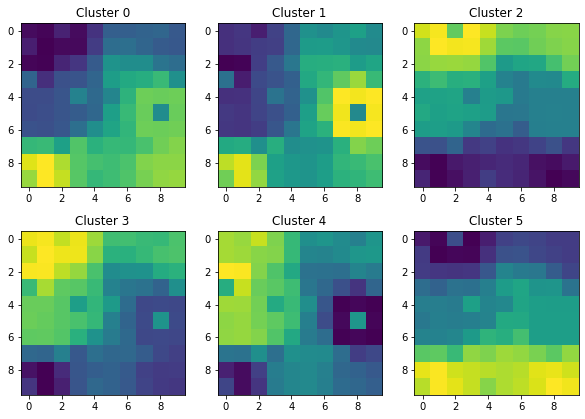

In [205]:
koh5 = KOH(
    xyhex, 
    (10,10),
    neighborhood=mexican_factory_no_t(distance_euclidean),
    slowdown_function=exp_slowdown_factory(0.1),
    evaluation_data=split)
koh5.train(50)
koh5.plot_evaluate()

Znacznie lepiej

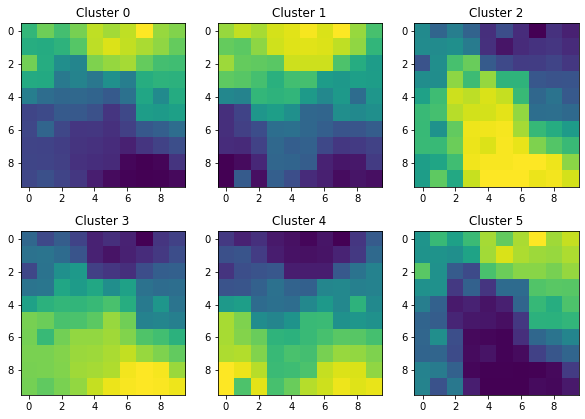

In [206]:
koh6 = KOH(
    xyhex, 
    (10,10),
    neighborhood=mexican_factory_no_t(distance_euclidean),
    slowdown_function=exp_slowdown_factory(0.1),
    evaluation_data=split)
koh6.train(100)
koh6.plot_evaluate()

Wygląda nieźle i zaczyna wyłapywać kilka klastrów. Tak jak się spodziewałem (0, 5) i (2, 3) są podobne w tych testach.

## Wpływ wielkości sieci i funkcji sąsiedztwa na skupienia na zbiorze hexagon
Będę badać wpływ liczby neuronów, rodzaj funkcji sąsiedztwa. Zacznę od 6 neuronów i będę zwiększać ich liczbę. Każdą sieć uruchamiam na 50 epok.

In [34]:
v_measures = {}
def run_test_suite(koh_net, train_time, name):
    koh_net.train(train_time)
    fig, axs = koh_net.plot_evaluate()
    fig.suptitle(f"{name} self-organizing map")
    plt.show()
    
    fig2d, axs2d = koh_net.plot_neurons_2d()
    axs2d.set_ylim(-10,10)
    axs2d.set_xlim(-10,10)
    axs2d.set_title(f"{name} neuron placement")
    plt.show()
    
    v_measures[name] = koh_net.v_measure(xyhex, chex)
    print(f"{name} v-measure: {koh_net.v_measure(xyhex, chex)}")

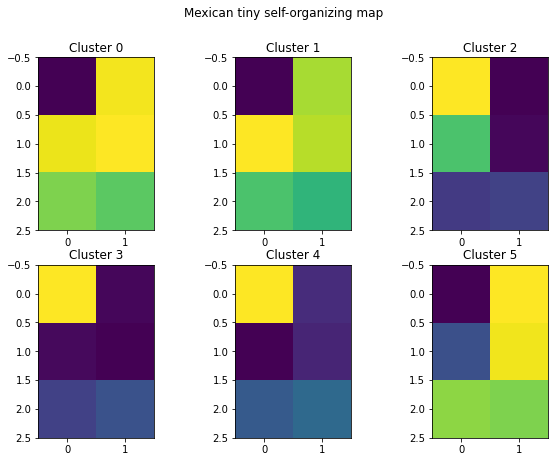

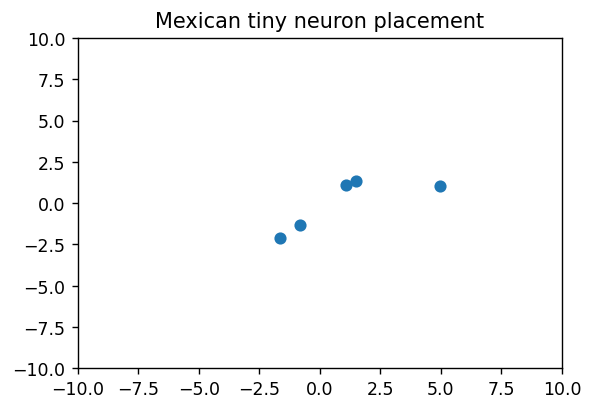

Mexican tiny v-measure: 0.6622559121786519


In [10]:
run_test_suite(
    KOH(
        xyhex, 
        (3,2),
        neighborhood=mexican_factory_no_t(distance_euclidean),
        slowdown_function=exp_slowdown_factory(0.1),
        evaluation_data=split
    ),
    50,
    "Mexican tiny"
)

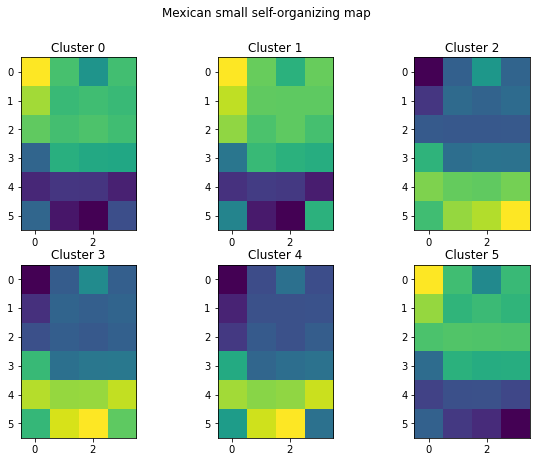

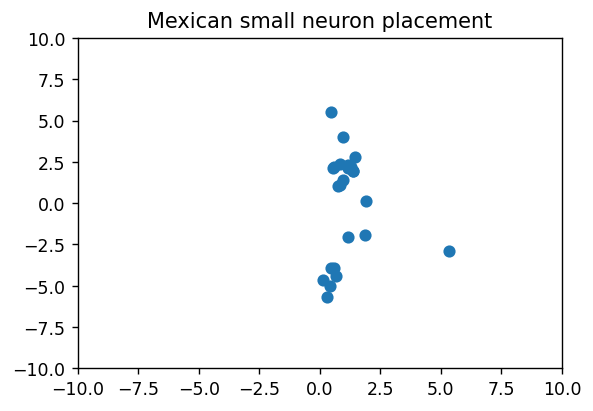

Mexican small v-measure: 0.7309665195631395


In [11]:
run_test_suite(
    KOH(
        xyhex, 
        (6,4),
        neighborhood=mexican_factory_no_t(distance_euclidean),
        slowdown_function=exp_slowdown_factory(0.1),
        evaluation_data=split
    ),
    50,
    "Mexican small"
)

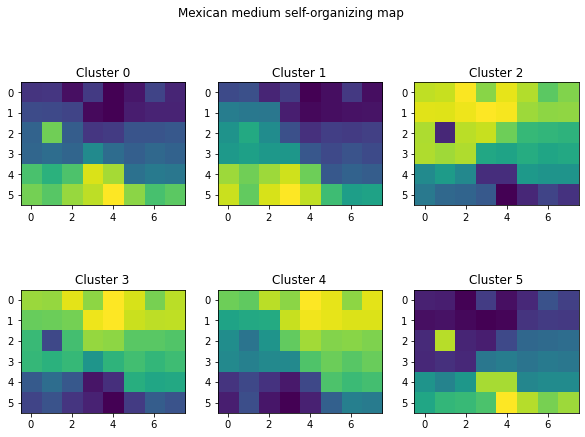

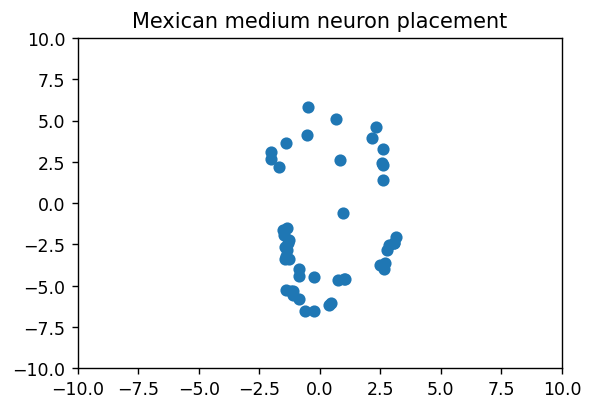

Mexican medium v-measure: 0.6664474042943852


In [12]:
run_test_suite(
    KOH(
        xyhex, 
        (6,8),
        neighborhood=mexican_factory_no_t(distance_euclidean),
        slowdown_function=exp_slowdown_factory(0.1),
        evaluation_data=split
    ),
    50,
    "Mexican medium"
)

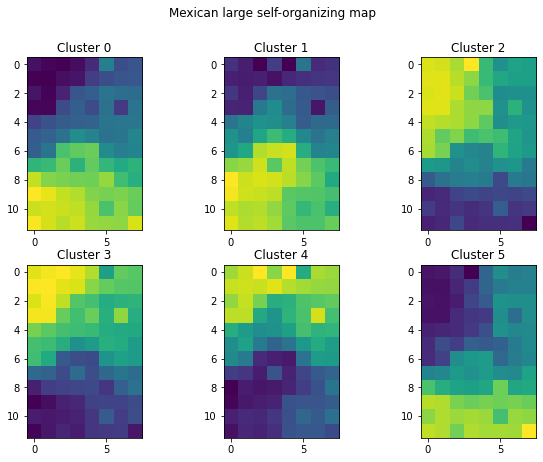

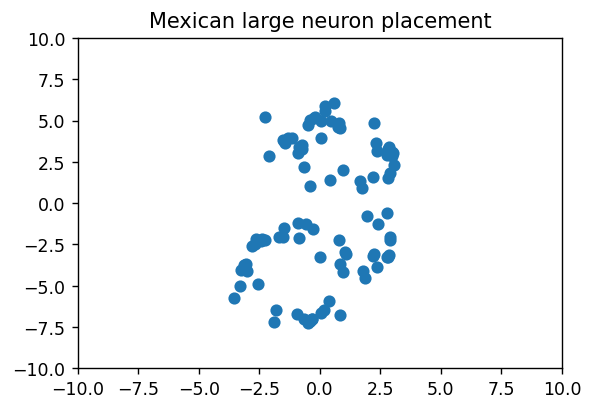

Mexican large v-measure: 0.6078996808497181


In [13]:
run_test_suite(
    KOH(
        xyhex, 
        (12,8),
        neighborhood=mexican_factory_no_t(distance_euclidean),
        slowdown_function=exp_slowdown_factory(0.1),
        evaluation_data=split
    ),
    50,
    "Mexican large"
)

Bardzo ładnie rozprowadzają się neurony.

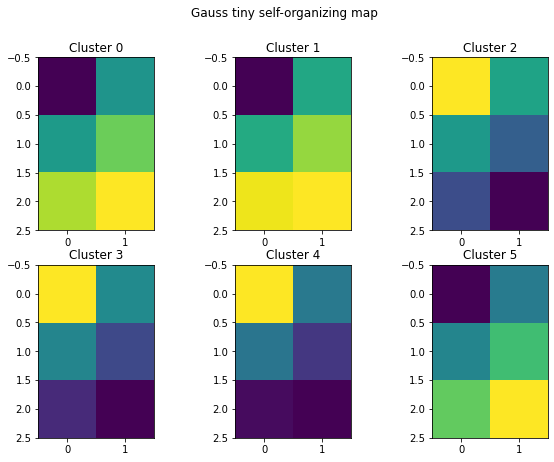

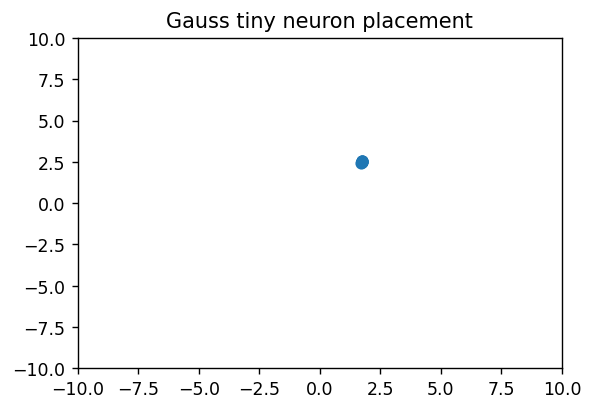

Gauss tiny v-measure: 0.41940637171564926


In [27]:
run_test_suite(
    KOH(
        xyhex, 
        (3,2),
        slowdown_function=exp_slowdown_factory(0.1),
        evaluation_data=split
    ),
    50,
    "Gauss tiny"
)

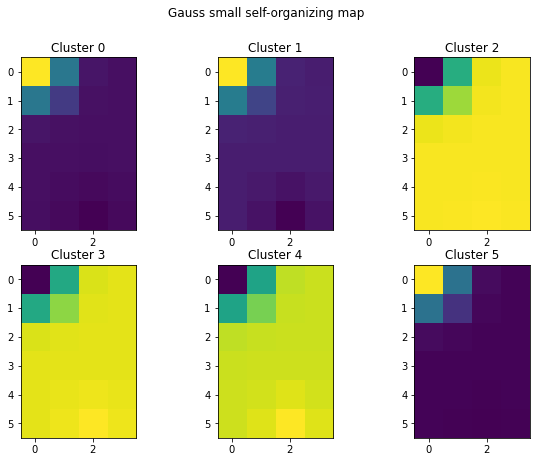

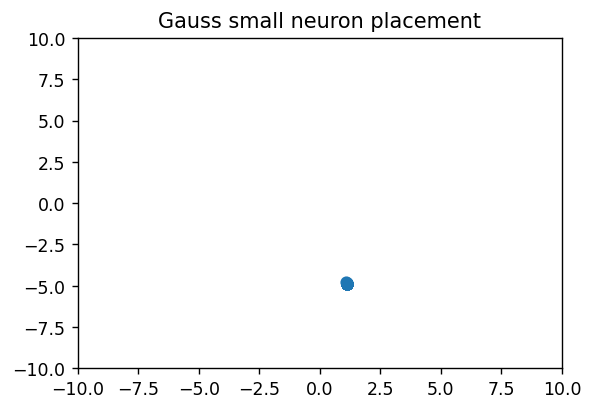

Gauss small v-measure: 0.3444489820236078


In [28]:
run_test_suite(
    KOH(
        xyhex, 
        (6,4),
        slowdown_function=exp_slowdown_factory(0.1),
        evaluation_data=split
    ),
    50,
    "Gauss small"
)

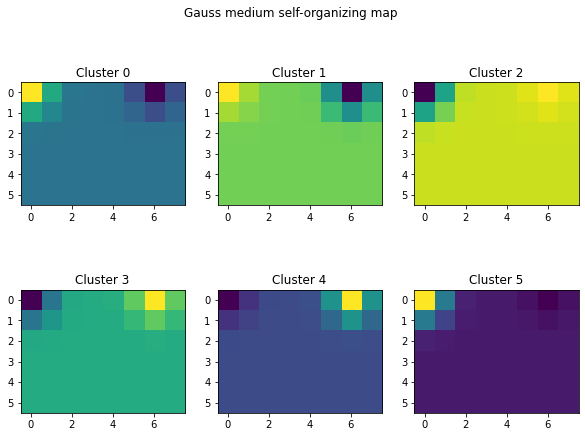

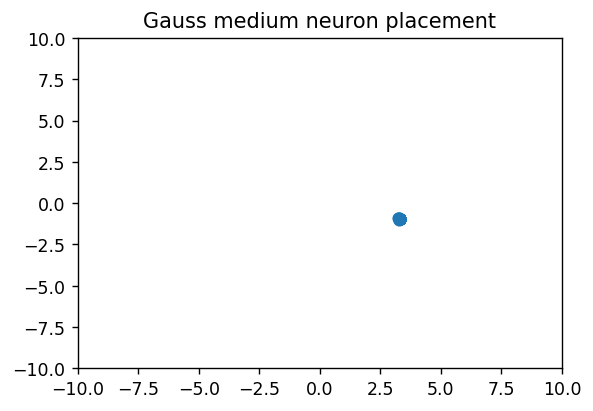

Gauss medium v-measure: 0.5048615812639372


In [29]:
run_test_suite(
    KOH(
        xyhex, 
        (6,8),
        slowdown_function=exp_slowdown_factory(0.1),
        evaluation_data=split
    ),
    50,
    "Gauss medium"
)

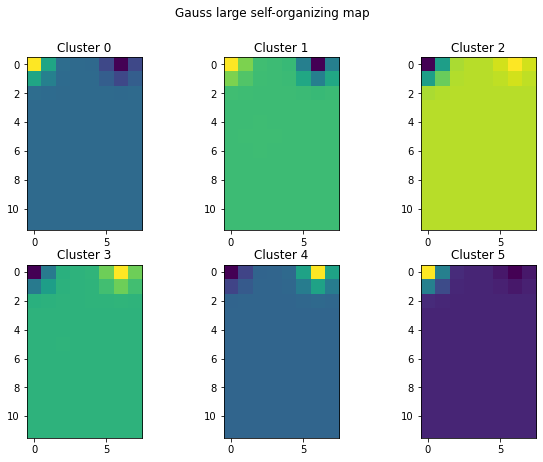

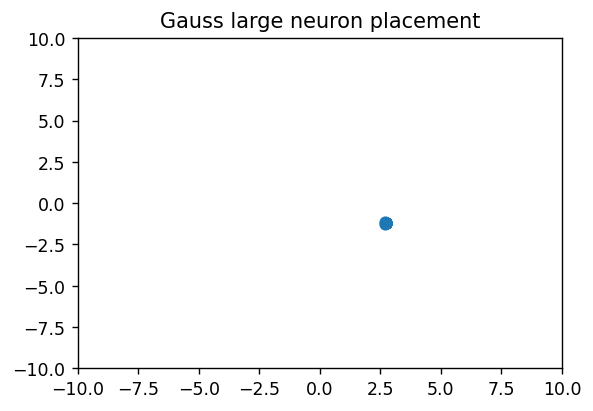

Gauss large v-measure: 0.49855728865592613


In [30]:
run_test_suite(
    KOH(
        xyhex, 
        (12,8),
        slowdown_function=exp_slowdown_factory(0.1),
        evaluation_data=split
    ),
    50,
    "Gauss large"
)

Gaussowskie mają problem z rozdzieleniem swoich neuronów.

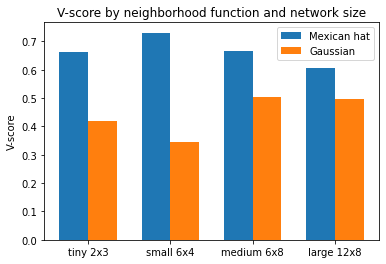

In [31]:
labels = ['tiny 2x3', 'small 6x4', 'medium 6x8', 'large 12x8']
mexican_means = [res for name, res in v_measures.items() if name[0] == "M"]
gauss_means = [res for name, res in v_measures.items() if name[0] == "G"]

x = np.arange(len(labels))
width = 0.35 

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mexican_means, width, label='Mexican hat')
rects2 = ax.bar(x + width/2, gauss_means, width, label='Gaussian')

ax.set_ylabel('V-score')
ax.set_title('V-score by neighborhood function and network size')
ax.set_xticks(x, labels)
ax.legend()

plt.show()

Dla funkcji meksykańskiego kapelusza mała sieć 6x4 daje najlepsze wyniki, ale dla fukcji gaussowskiej najgorsze. Wygląda na to, że sieć z funkcją gaussowską miała problemy z rozdzielaniem swoich neuronów, ciężko mi w tej chwili stwierdzić czy to jest błąd implementacyjny, czy takie powinno być zachowanie sieci. 

## Wpływ wygaszania na zbiorze hexagon
Najlepsze wyniki daje mała sieć z funkcją kapelusza, więc dalej z niej korzystam.

In [41]:
v_measures_alpha = {}
def run_test_suite_alpha(koh_net, train_time, name):
    koh_net.train(train_time)
    fig, axs = koh_net.plot_evaluate()
    fig.suptitle(f"{name} self-organizing map")
    plt.show()
    
    fig2d, axs2d = koh_net.plot_neurons_2d()
    axs2d.set_ylim(-10,10)
    axs2d.set_xlim(-10,10)
    axs2d.set_title(f"{name} neuron placement")
    plt.show()
    
    v_measures_alpha[name] = koh_net.v_measure(xyhex, chex)
    print(f"{name} v-measure: {koh_net.v_measure(xyhex, chex)}")

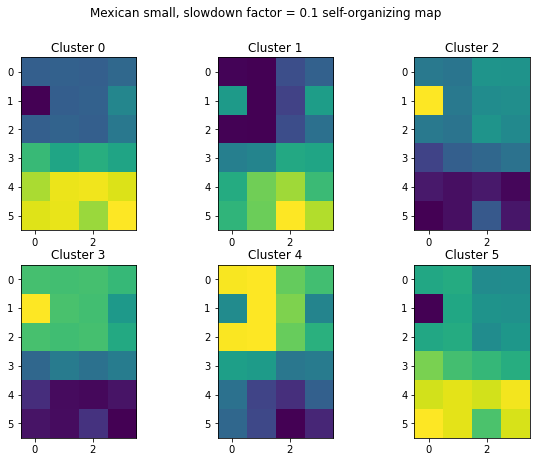

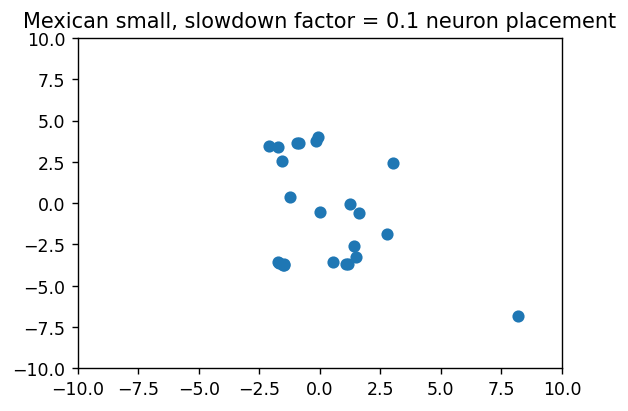

Mexican small, slowdown factor = 0.1 v-measure: 0.7625110333529487


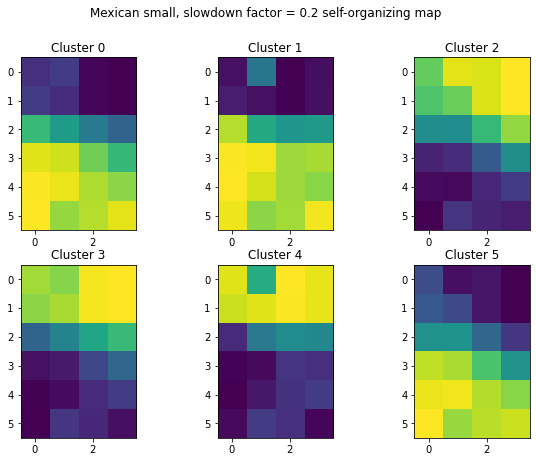

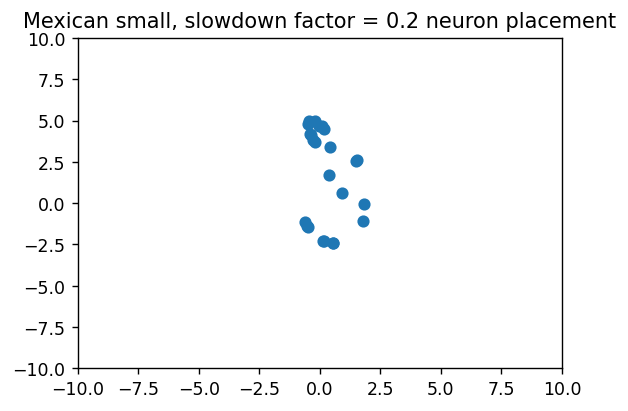

Mexican small, slowdown factor = 0.2 v-measure: 0.7075102199648416


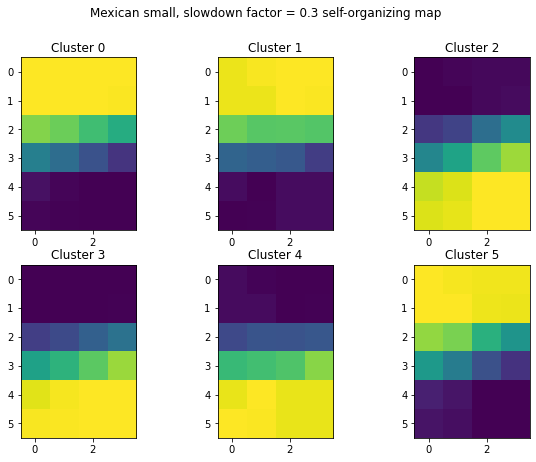

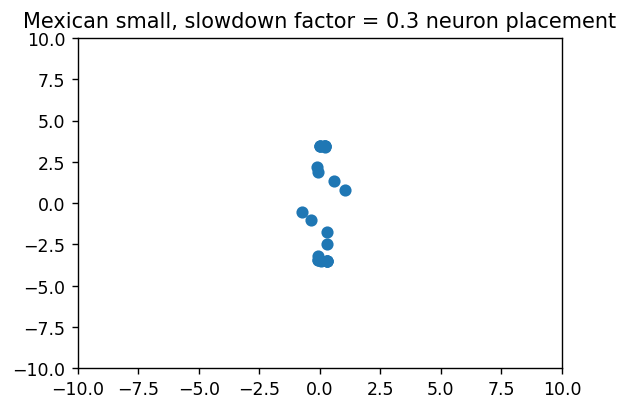

Mexican small, slowdown factor = 0.3 v-measure: 0.6605595819136102


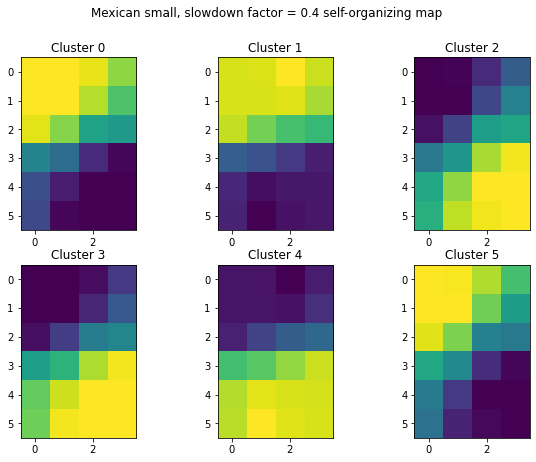

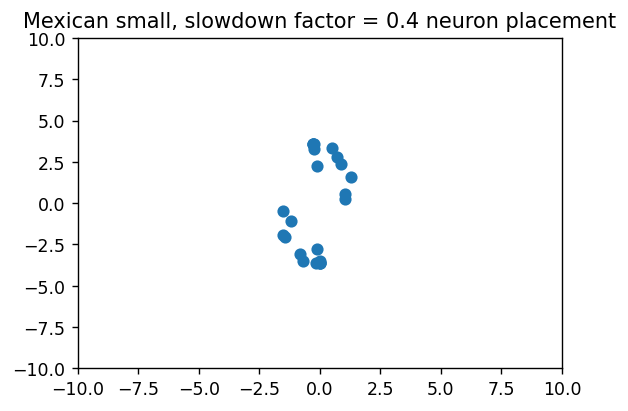

Mexican small, slowdown factor = 0.4 v-measure: 0.6416127443756142


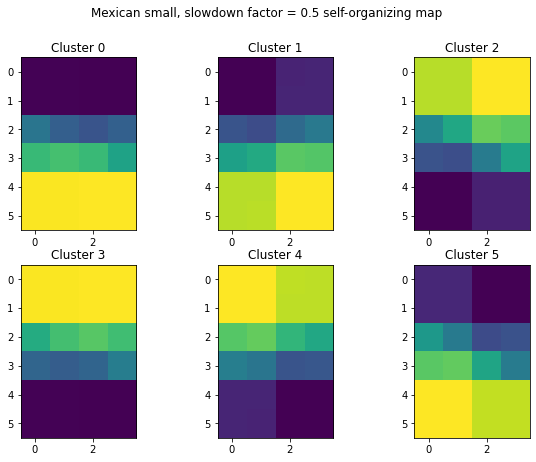

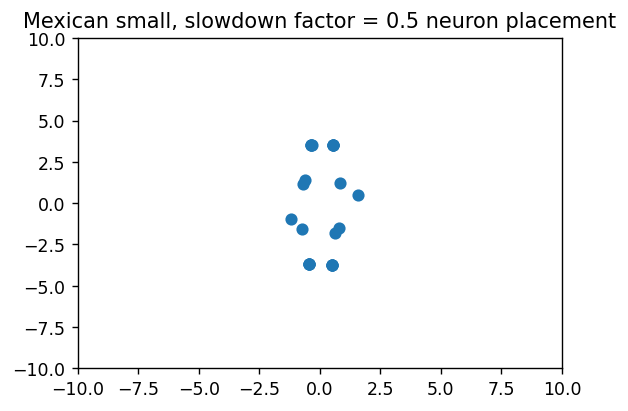

Mexican small, slowdown factor = 0.5 v-measure: 0.6511567345004724


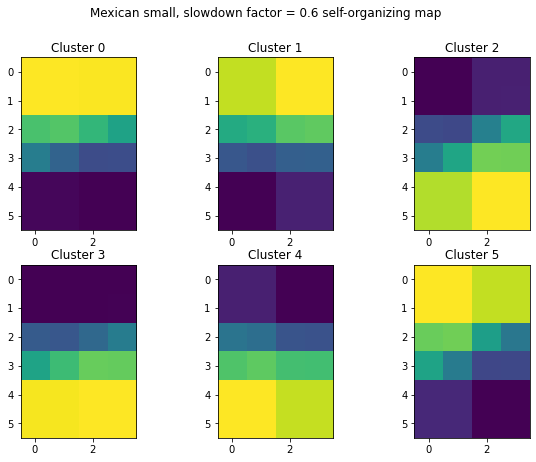

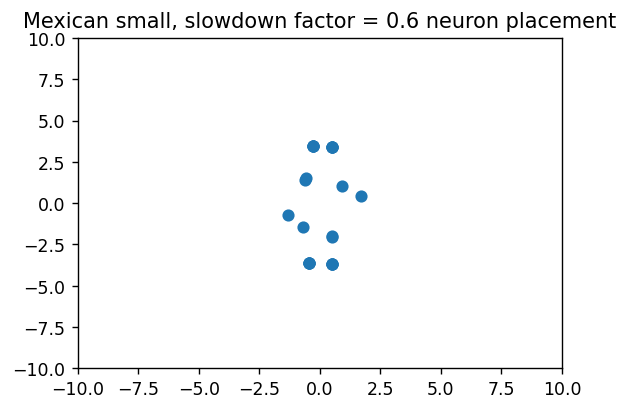

Mexican small, slowdown factor = 0.6 v-measure: 0.6658983446466783


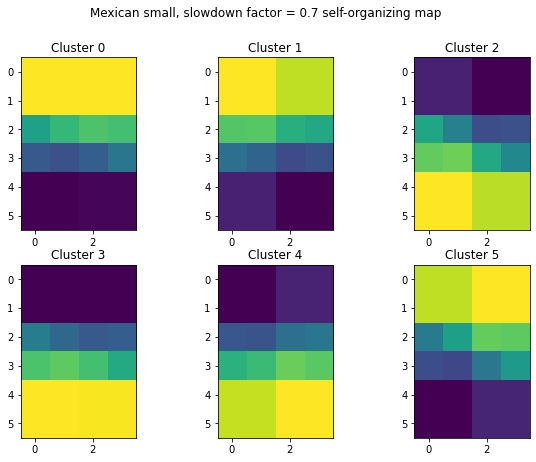

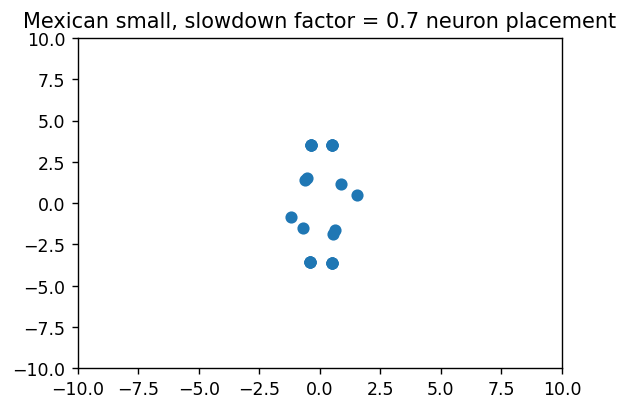

Mexican small, slowdown factor = 0.7 v-measure: 0.6540626275184117


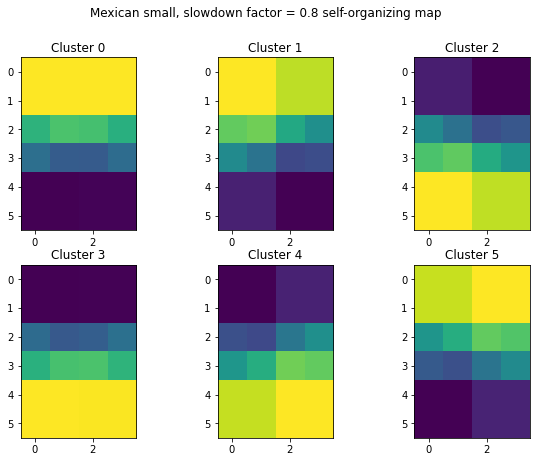

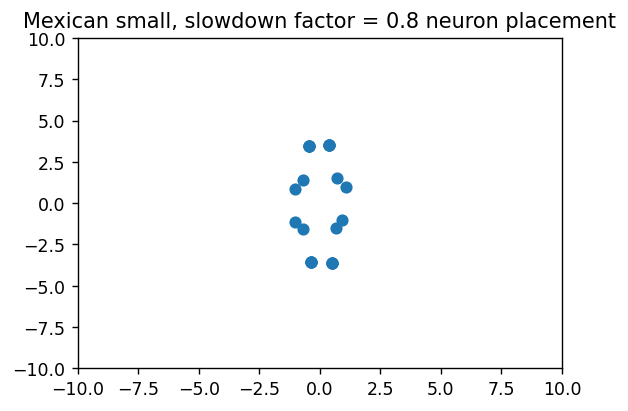

Mexican small, slowdown factor = 0.8 v-measure: 0.6455843158842006


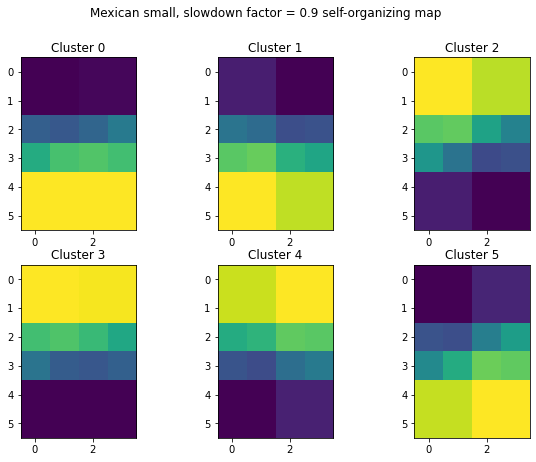

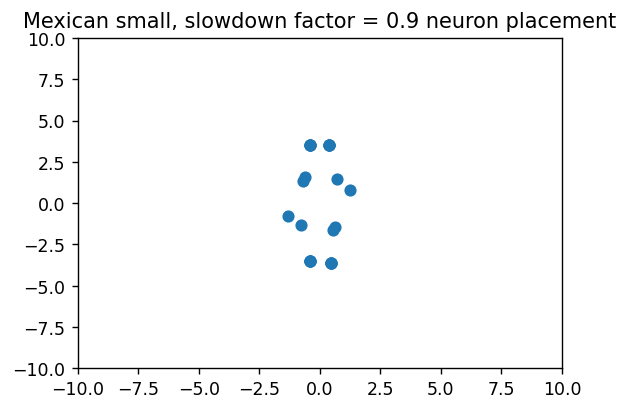

Mexican small, slowdown factor = 0.9 v-measure: 0.6294656269105077


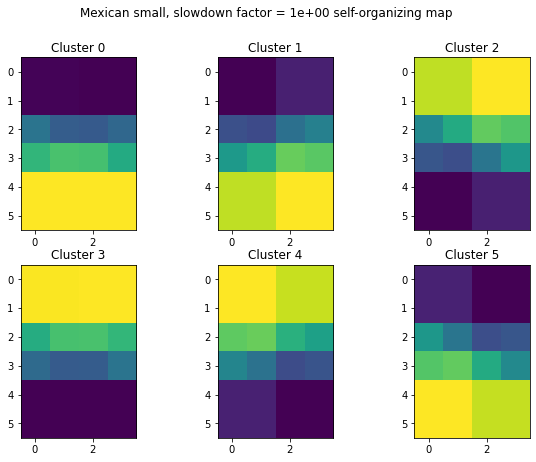

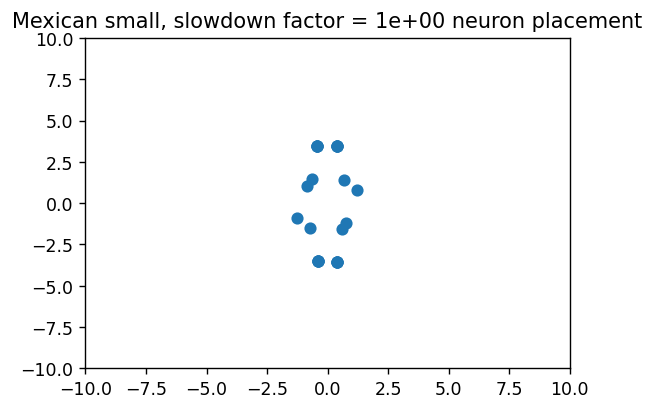

Mexican small, slowdown factor = 1e+00 v-measure: 0.615084966050723


In [42]:
for i in range(1, 11):
    run_test_suite_alpha(
        KOH(
            xyhex, 
            (6,4),
            neighborhood=mexican_factory_no_t(distance_euclidean),
            slowdown_function=exp_slowdown_factory(i/10),
            evaluation_data=split
        ),
        50,
        f"Mexican small, slowdown factor = {i/10:.1}"
    )

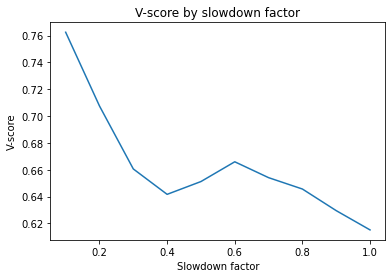

In [45]:
plt.plot(
    [round(i/10, 1) for i in range(1, 11)],
    v_measures_alpha.values()
)
plt.title("V-score by slowdown factor")
plt.ylabel("V-score")
plt.xlabel("Slowdown factor")
plt.show()

Niskie wartości dla małych mogą sugerować, że sieć jeszcze się nie nauczyłą, ale ciężko mi wytłumaczyć górkę w 0.6. W każdym razie, wartości 0.1 i 0.6 mogą być optymalne, więc będę je analizować dalej.

## Wpływ skalowania sąsiedztwa na zbiorze hexagon

In [74]:
def mexican_factory_scale_no_t(metric, scale):
    def mexican(n1, n2, t):
        d = scale * metric(np.array(n1), np.array(n2))
        exp_part = np.exp(- d**2)
        mult_part = (2 - 4 * d**2)
        return - mult_part * exp_part
    return mexican

In [75]:
v_measures_scale = {}
def run_test_suite_scale(koh_net, train_time, name):
    koh_net.train(train_time)
    fig, axs = koh_net.plot_evaluate()
    fig.suptitle(f"{name} self-organizing map")
    plt.show()
    
    fig2d, axs2d = koh_net.plot_neurons_2d()
    axs2d.set_ylim(-10,10)
    axs2d.set_xlim(-10,10)
    axs2d.set_title(f"{name} neuron placement")
    plt.show()
    
    v_measures_scale[name] = koh_net.v_measure(xyhex, chex)
    print(f"{name} v-measure: {koh_net.v_measure(xyhex, chex)}")

/tmp/ipykernel_227055/1906100306.py:2: RuntimeWarning: overflow encountered in square
  return np.sqrt(np.sum((x - y)**2))
/home/kacper/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


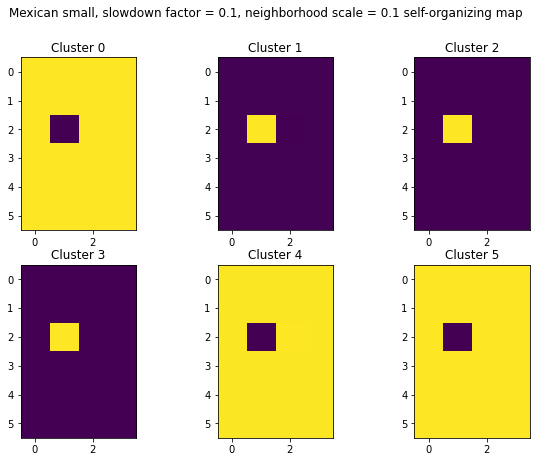

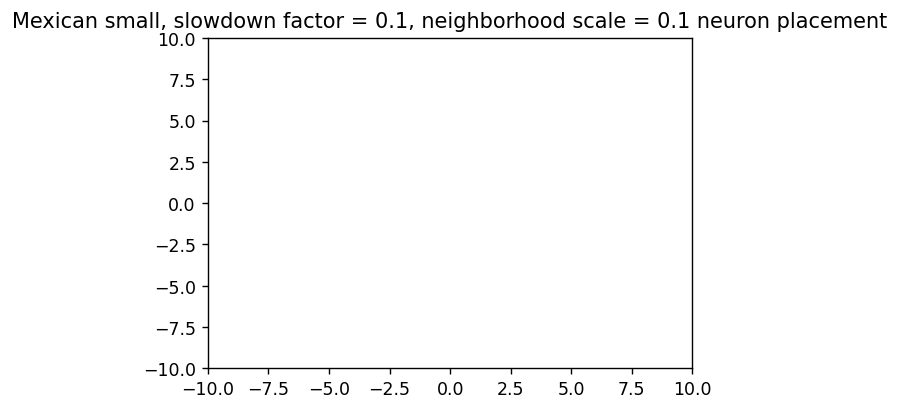

/tmp/ipykernel_227055/1906100306.py:2: RuntimeWarning: overflow encountered in square
  return np.sqrt(np.sum((x - y)**2))


Mexican small, slowdown factor = 0.1, neighborhood scale = 0.1 v-measure: 0.0


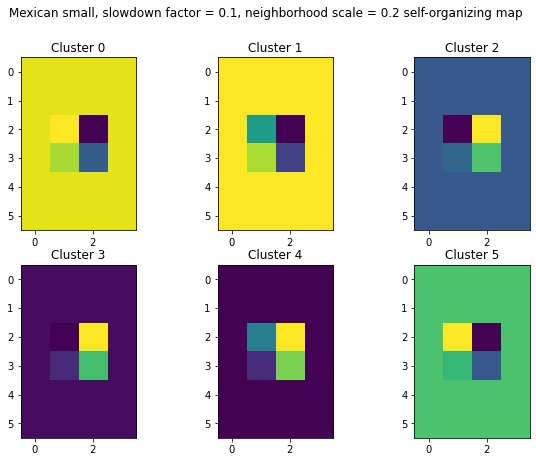

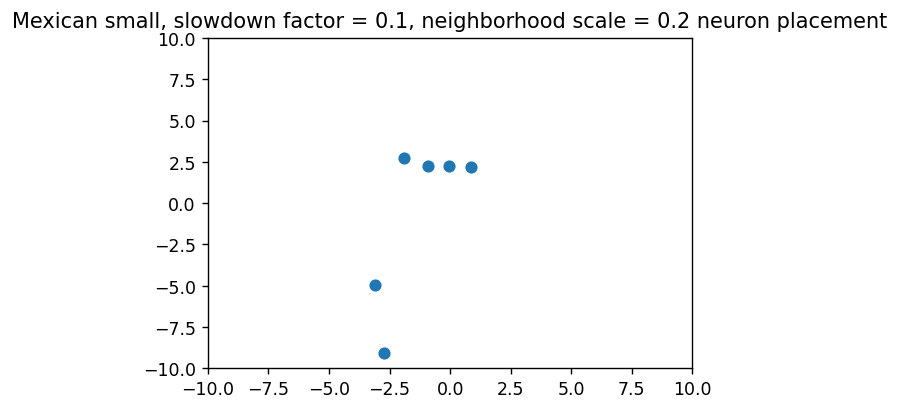

Mexican small, slowdown factor = 0.1, neighborhood scale = 0.2 v-measure: 0.6164920181635313


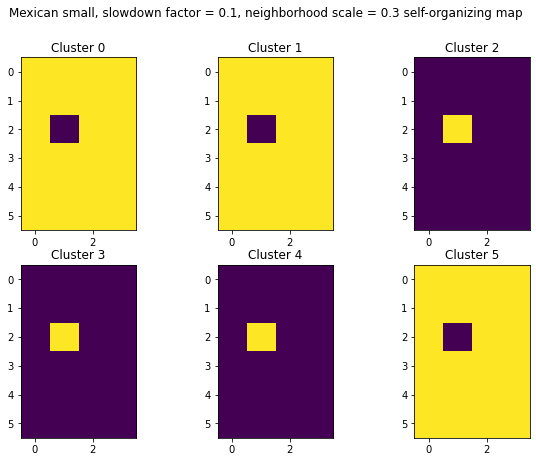

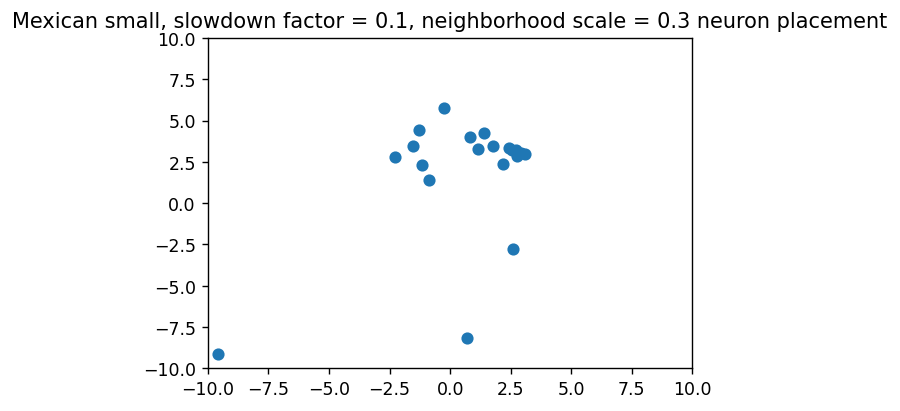

Mexican small, slowdown factor = 0.1, neighborhood scale = 0.3 v-measure: 0.7190271793666518


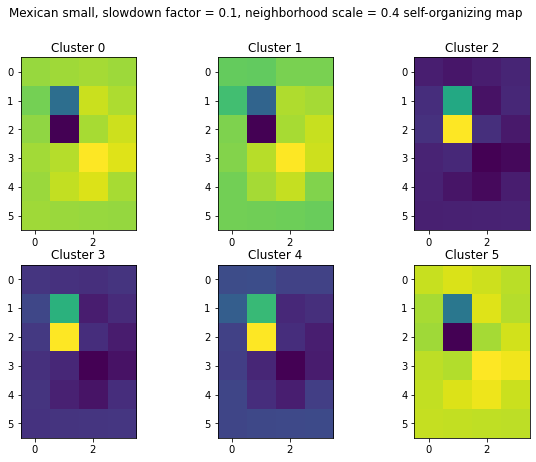

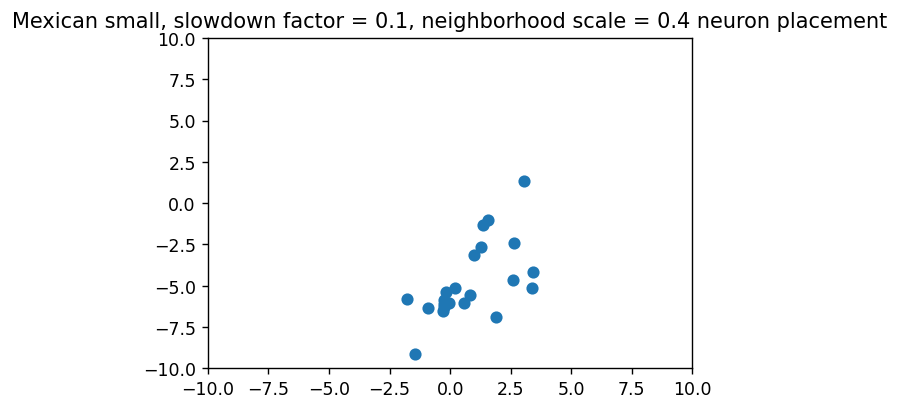

Mexican small, slowdown factor = 0.1, neighborhood scale = 0.4 v-measure: 0.6213108724754094


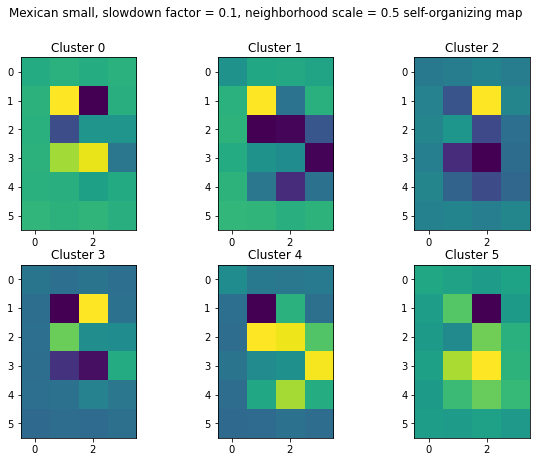

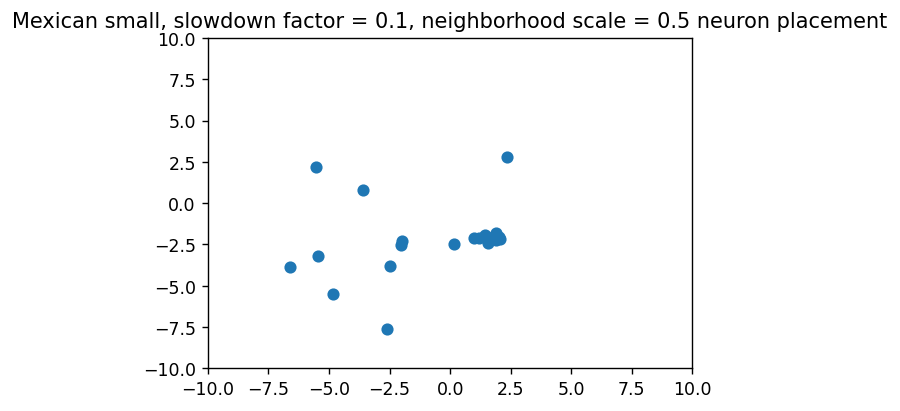

Mexican small, slowdown factor = 0.1, neighborhood scale = 0.5 v-measure: 0.7299502630419978


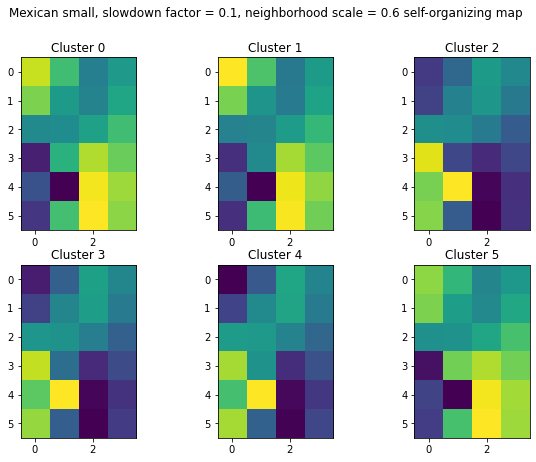

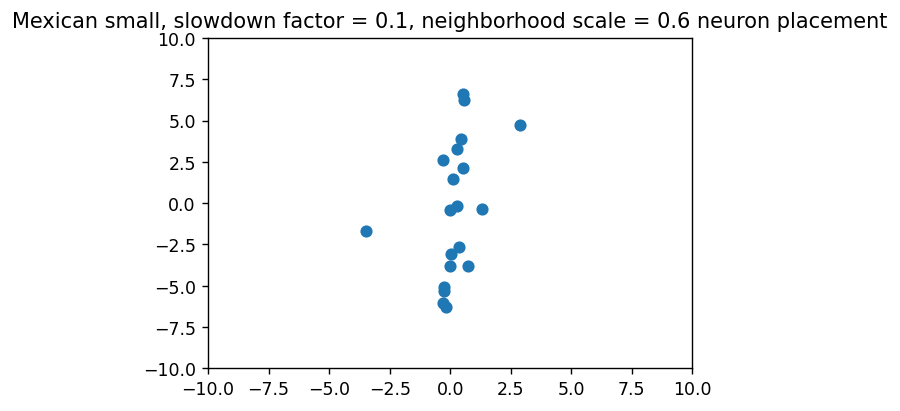

Mexican small, slowdown factor = 0.1, neighborhood scale = 0.6 v-measure: 0.7279217228983607


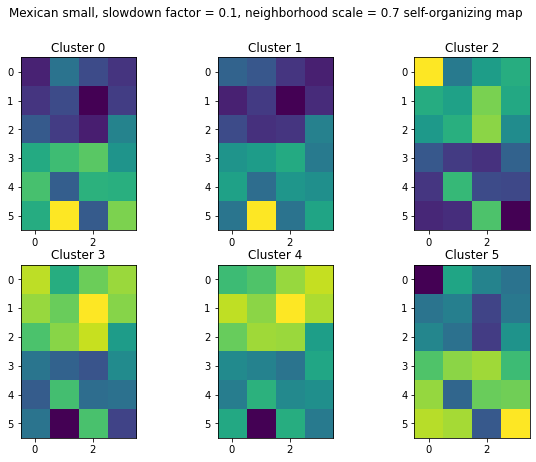

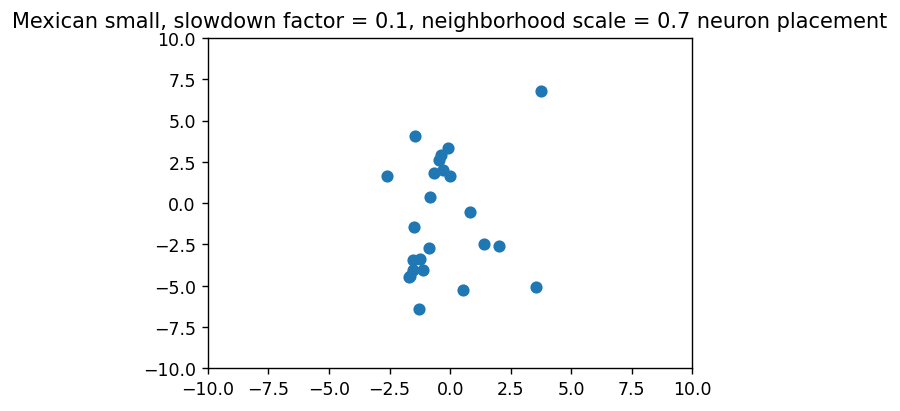

Mexican small, slowdown factor = 0.1, neighborhood scale = 0.7 v-measure: 0.7152011783900437


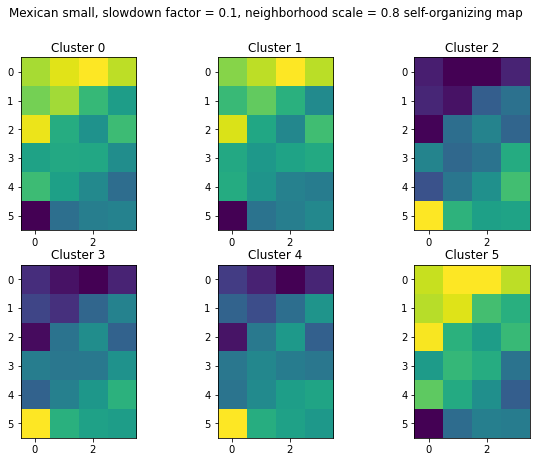

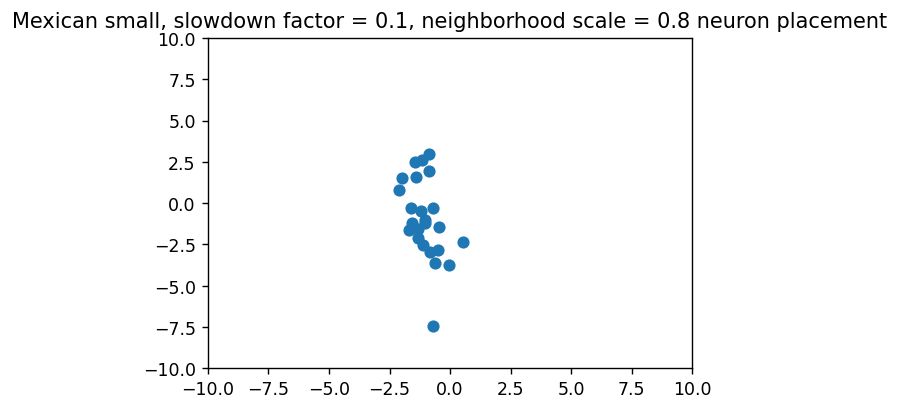

Mexican small, slowdown factor = 0.1, neighborhood scale = 0.8 v-measure: 0.7006000958101368


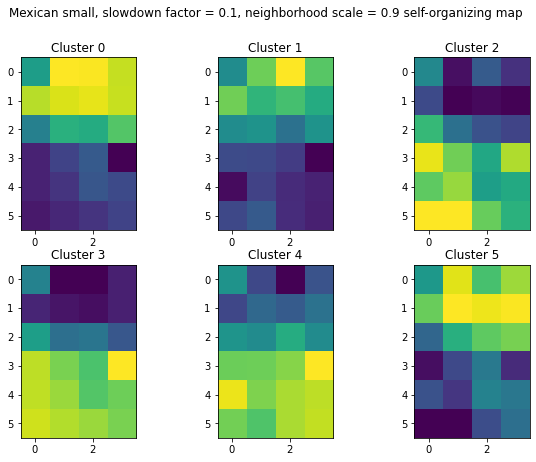

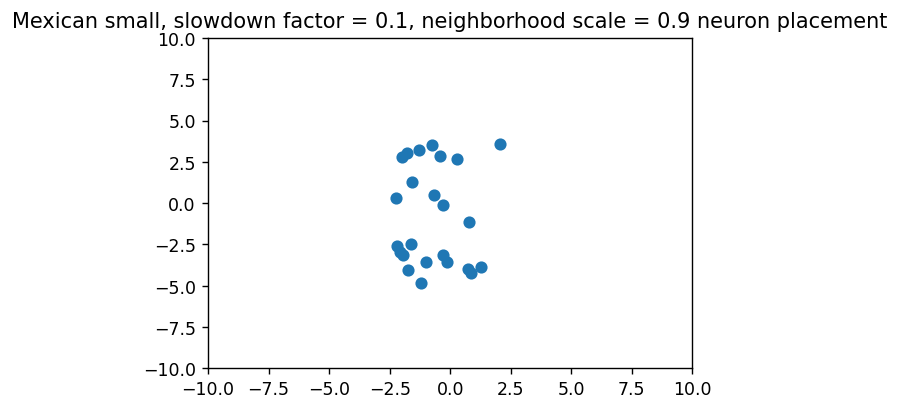

Mexican small, slowdown factor = 0.1, neighborhood scale = 0.9 v-measure: 0.7475572590753344


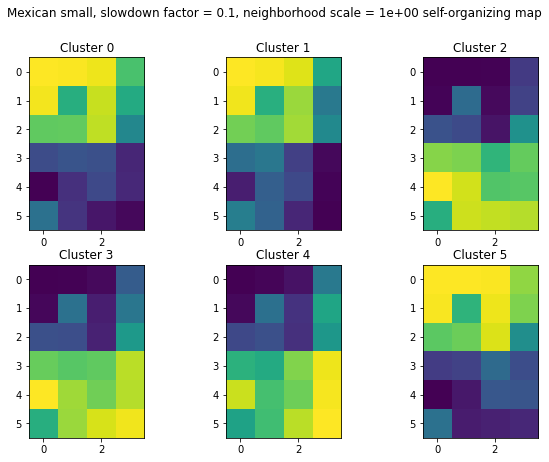

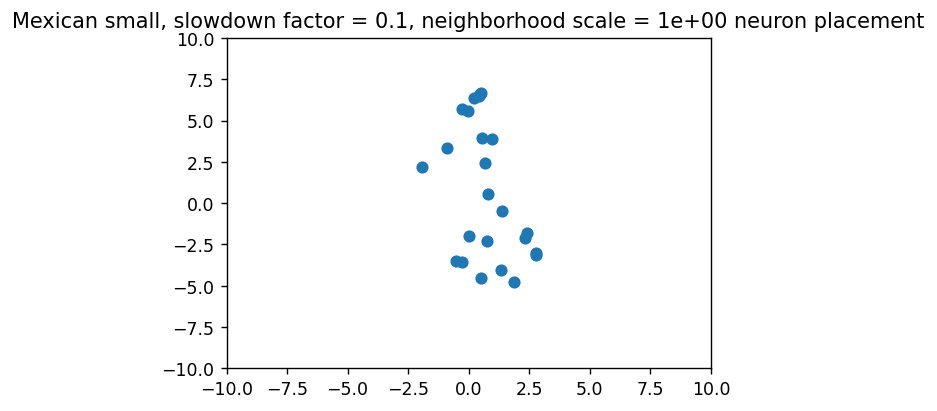

Mexican small, slowdown factor = 0.1, neighborhood scale = 1e+00 v-measure: 0.7588261898062939


/tmp/ipykernel_227055/1906100306.py:2: RuntimeWarning: overflow encountered in square
  return np.sqrt(np.sum((x - y)**2))


/tmp/ipykernel_227055/4049533898.py:41: RuntimeWarning: overflow encountered in add
  self.weights[:, i, j] += distance * a * diff


/home/kacper/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/kacper/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/kacper/.local/lib/python3.9/site-packages/matplotlib/image.py:446: RuntimeWarning: overflow encountered in double_scalars
  newmin = vmid - dv * fact
/home/kacper/.local/lib/python3.9/site-packages/matplotlib/image.py:451: RuntimeWarning: overflow encountered in double_scalars
  newmax = vmid + dv * fact


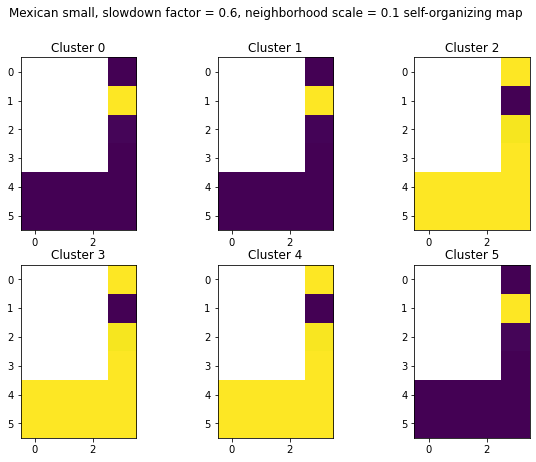

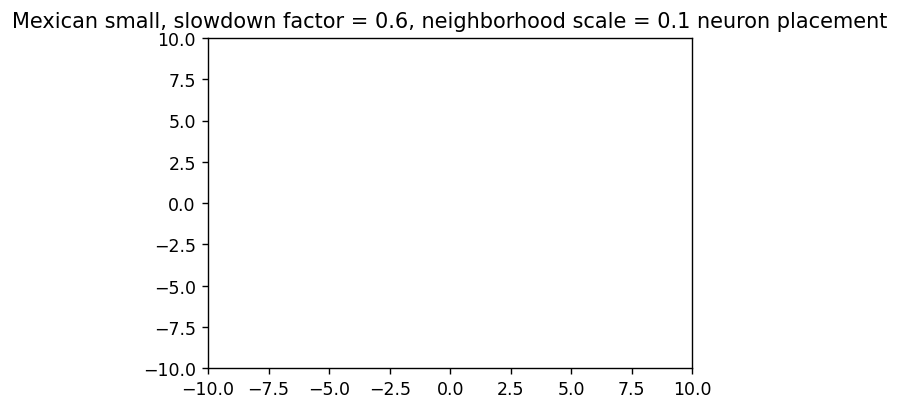

/tmp/ipykernel_227055/1906100306.py:2: RuntimeWarning: overflow encountered in square
  return np.sqrt(np.sum((x - y)**2))


Mexican small, slowdown factor = 0.6, neighborhood scale = 0.1 v-measure: 0.0


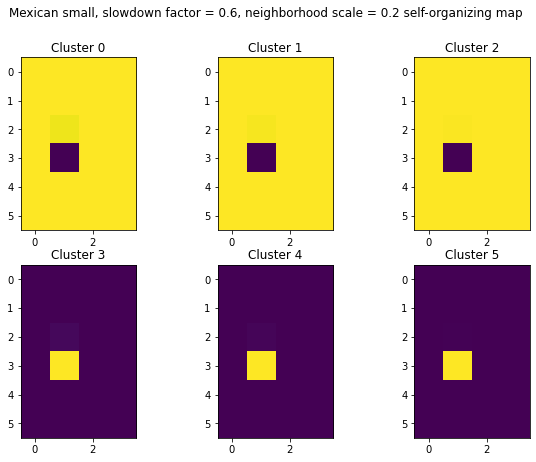

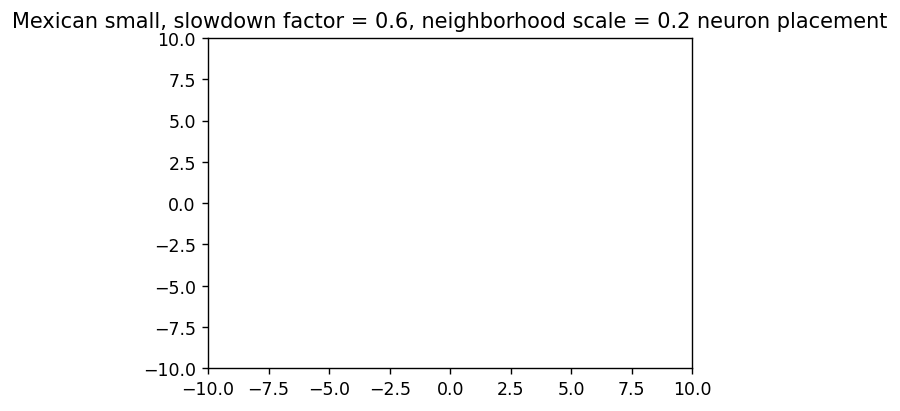

Mexican small, slowdown factor = 0.6, neighborhood scale = 0.2 v-measure: 0.4920969210842555


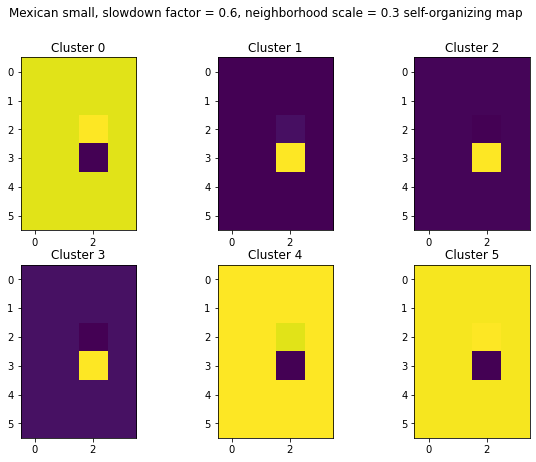

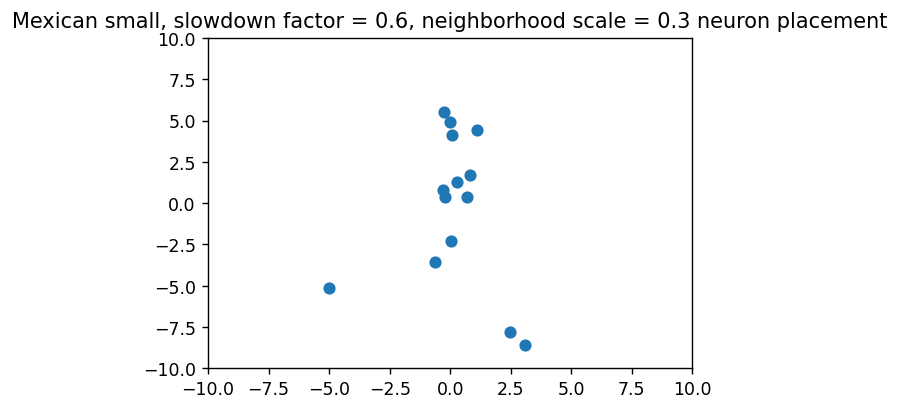

Mexican small, slowdown factor = 0.6, neighborhood scale = 0.3 v-measure: 0.6912409157826003


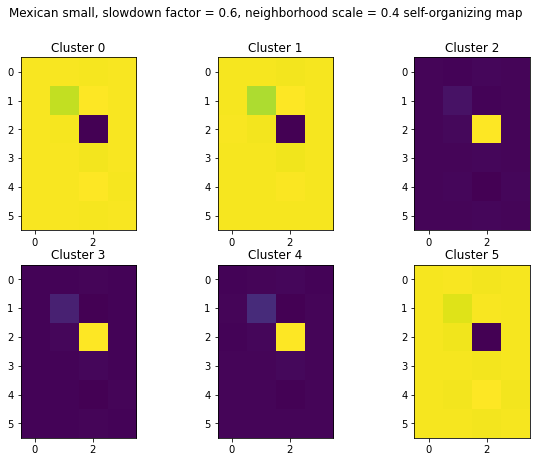

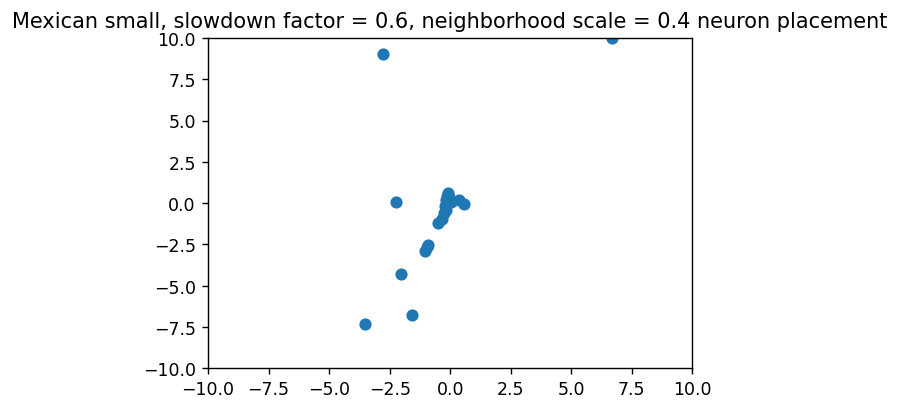

Mexican small, slowdown factor = 0.6, neighborhood scale = 0.4 v-measure: 0.6589348890855669


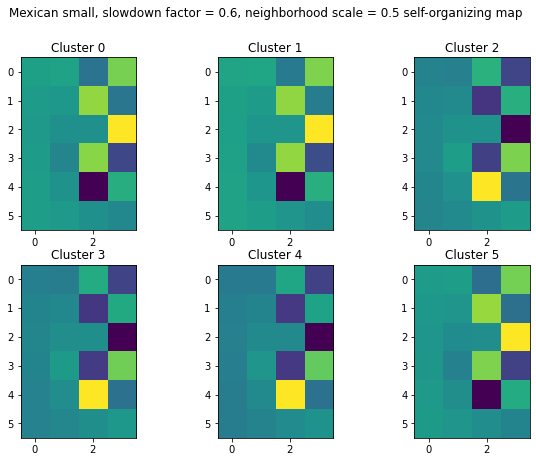

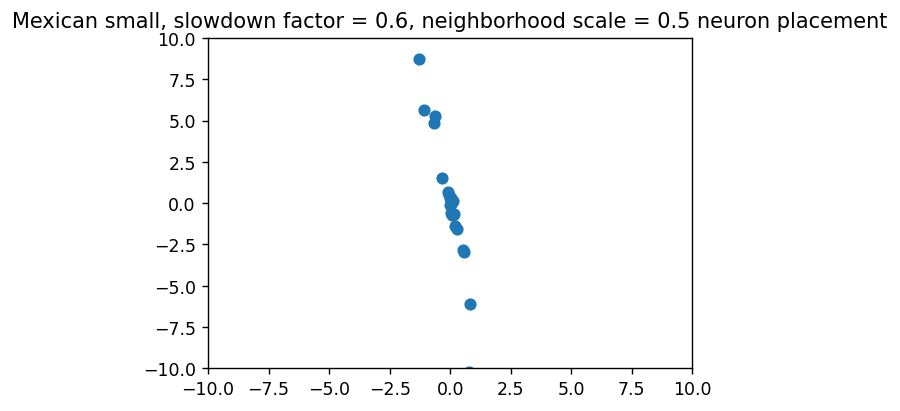

Mexican small, slowdown factor = 0.6, neighborhood scale = 0.5 v-measure: 0.5868837110187967


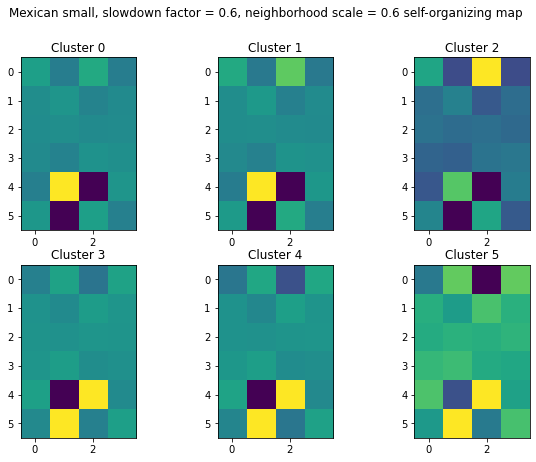

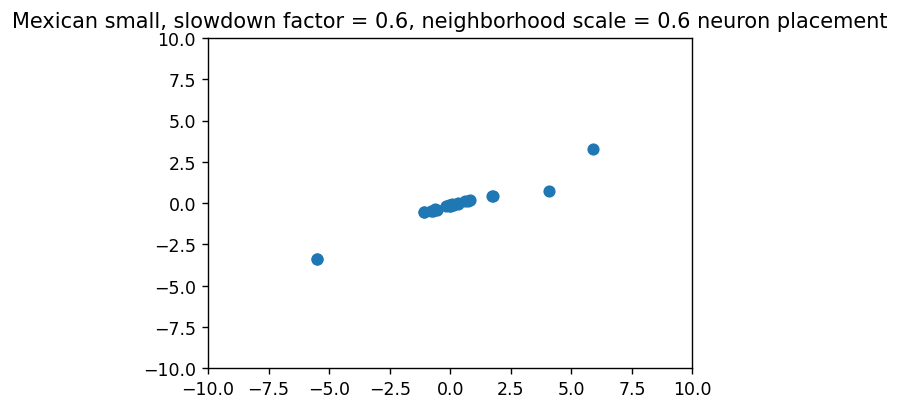

Mexican small, slowdown factor = 0.6, neighborhood scale = 0.6 v-measure: 0.5196908988377573


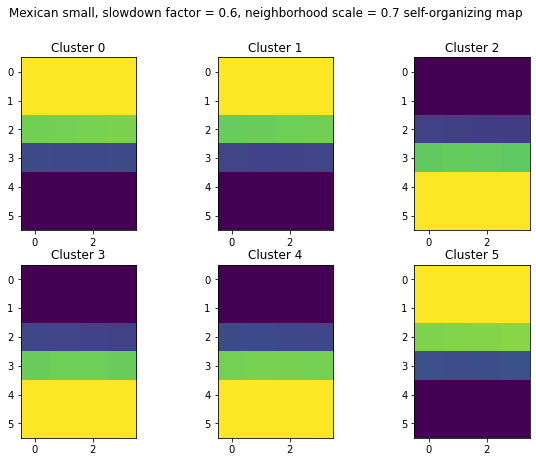

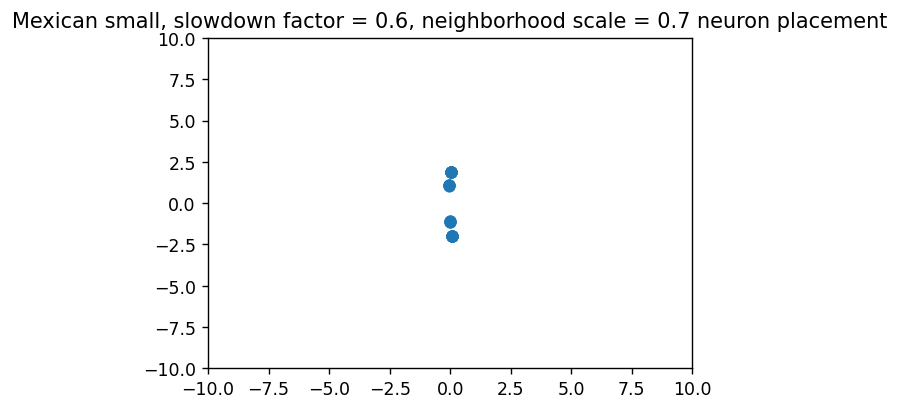

Mexican small, slowdown factor = 0.6, neighborhood scale = 0.7 v-measure: 0.4853328075824682


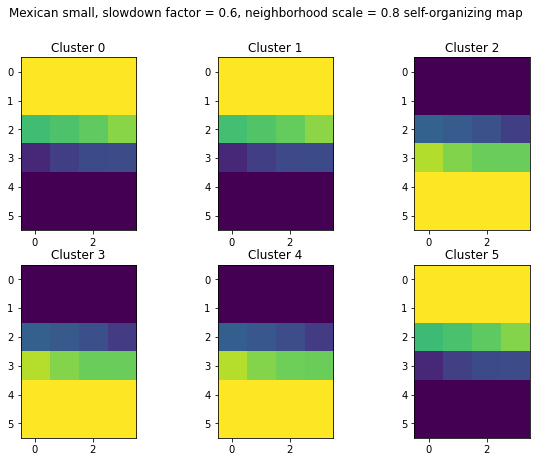

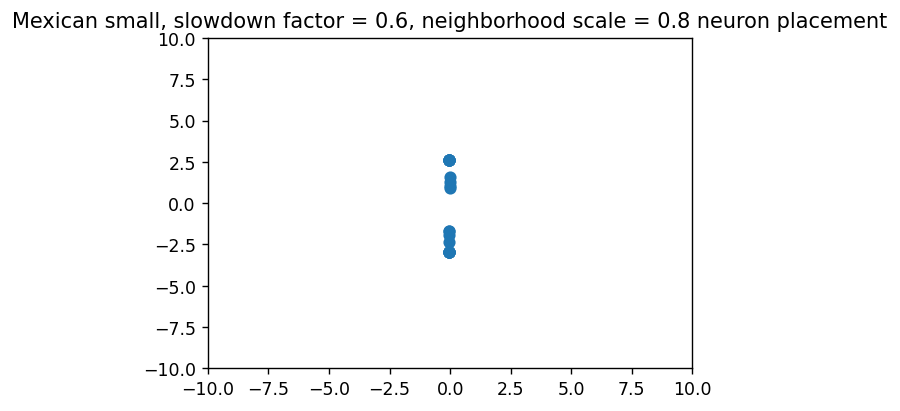

Mexican small, slowdown factor = 0.6, neighborhood scale = 0.8 v-measure: 0.4658361986101988


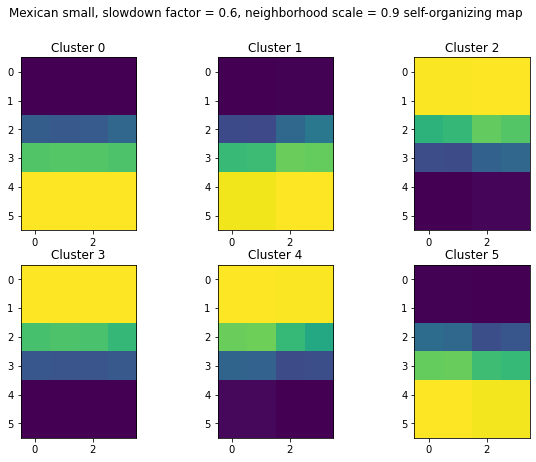

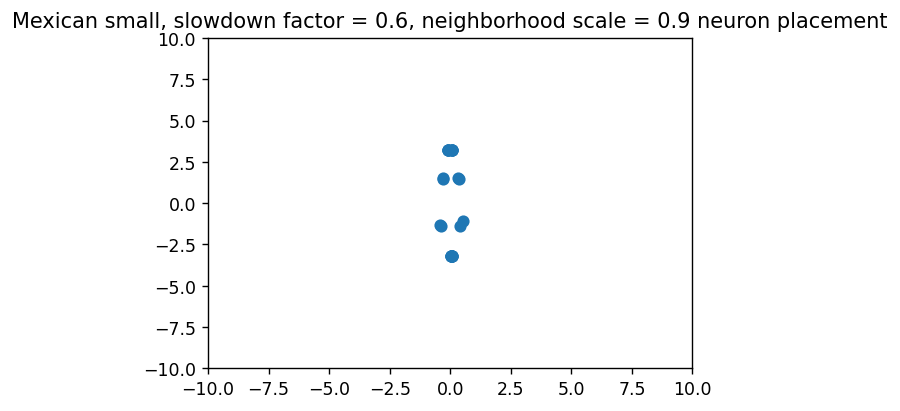

Mexican small, slowdown factor = 0.6, neighborhood scale = 0.9 v-measure: 0.6524664834363928


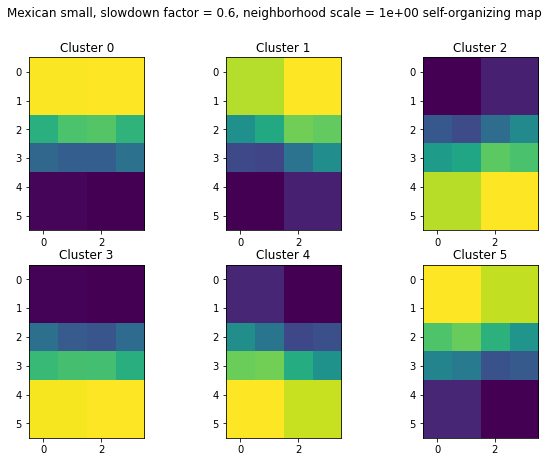

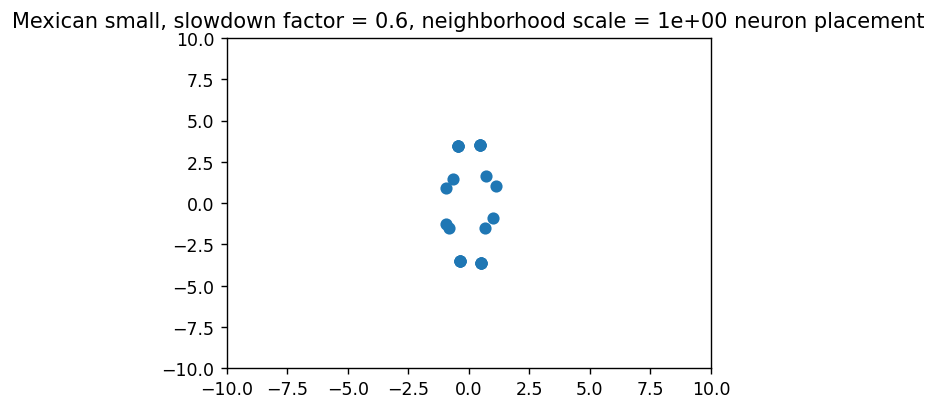

Mexican small, slowdown factor = 0.6, neighborhood scale = 1e+00 v-measure: 0.6449677002269902


In [76]:
for i in range(1, 11):
    run_test_suite_scale(
        KOH(
            xyhex, 
            (6,4),
            neighborhood=mexican_factory_scale_no_t(distance_euclidean, i/10),
            slowdown_function=exp_slowdown_factory(0.1),
            evaluation_data=split
        ),
        50,
        f"Mexican small, slowdown factor = 0.1, neighborhood scale = {i/10:.1}"
    )
for i in range(1, 11):
    run_test_suite_scale(
        KOH(
            xyhex, 
            (6,4),
            neighborhood=mexican_factory_scale_no_t(distance_euclidean, i/10),
            slowdown_function=exp_slowdown_factory(0.6),
            evaluation_data=split
        ),
        50,
        f"Mexican small, slowdown factor = 0.6, neighborhood scale = {i/10:.1}"
    )

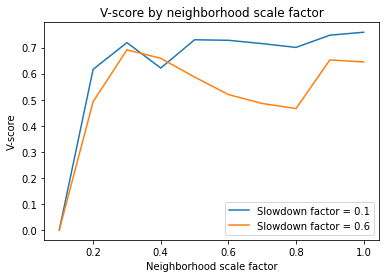

In [79]:
plt.plot(
    [round(i/10, 1) for i in range(1, 11)],
    [v for k, v in v_measures_scale.items() if k[35] == "1"]
)
plt.plot(
    [round(i/10, 1) for i in range(1, 11)],
    [v for k, v in v_measures_scale.items() if k[35] == "6"]
)
plt.title("V-score by neighborhood scale factor")
plt.ylabel("V-score")
plt.xlabel("Neighborhood scale factor")
plt.legend(["Slowdown factor = 0.1", "Slowdown factor = 0.6"])
plt.show()

Ponownie mamy jedno spodziewane maksimum w 1.0 i jedno nietypowe maksimum lokalne w 0.3. Dla niskich wartości były problemy, ale dla każdego innego wyniki w sumie były podobne.

## Cube
Skupiłem się na badaniu zbioru hexagon, dla cube wykonam tylko pierwszy eksperyment - zależności od funkcji sąsiedztwa i wielkości sieci. Dodatkowo, nie będę rysował wykresów z neuronami. Uznałem, że i tak ciężko stwierdzić po nich jakość skupienia, chyba że coś się popsuło - wtedy i tak będzie to widać na v-score i na heatmapie.

In [95]:
v_measures_cube = {}
def run_test_suite_cube(koh_net, train_time, name):
    koh_net.train(train_time)
    fig, axs = koh_net.plot_evaluate(nrow=2, ncol=4)
    fig.suptitle(f"{name} self-organizing map")
    plt.show()
    
    v_measures_cube[name] = koh_net.v_measure(data_cub, ccub)
    print(f"{name} v-measure: {koh_net.v_measure(data_cub, ccub)}")

Gauss tiny:


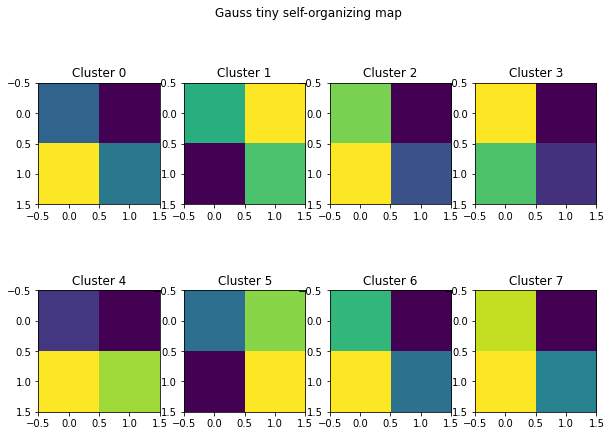

Gauss tiny v-measure: 0.5920136853884389
Gauss small:


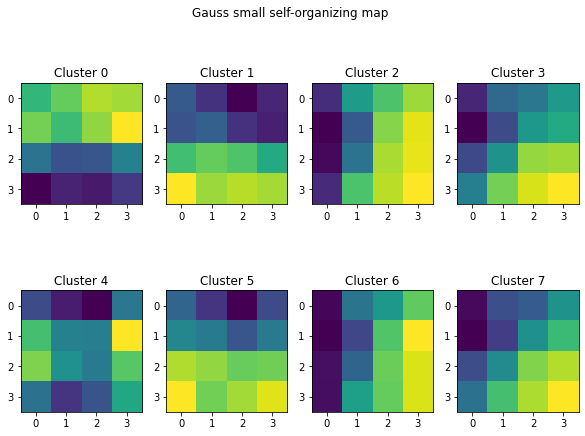

Gauss small v-measure: 0.722424566495215
Gauss medium:


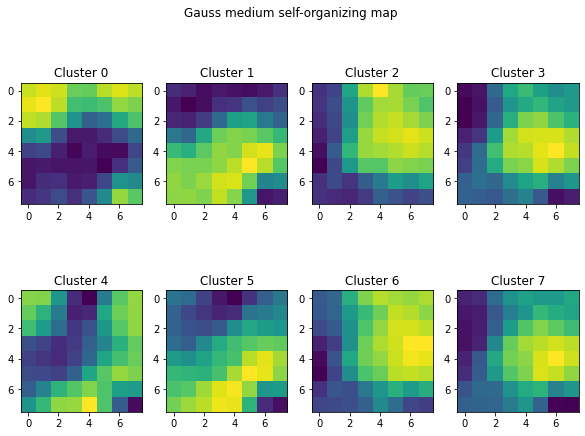

Gauss medium v-measure: 0.6505738059866888
Gauss large:


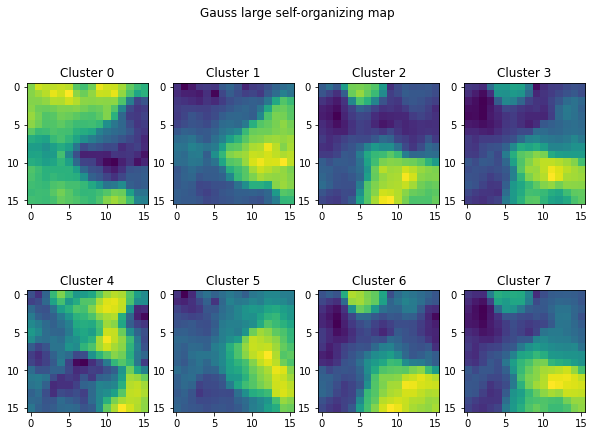

Gauss large v-measure: 0.5531195644672239
Mexican tiny:


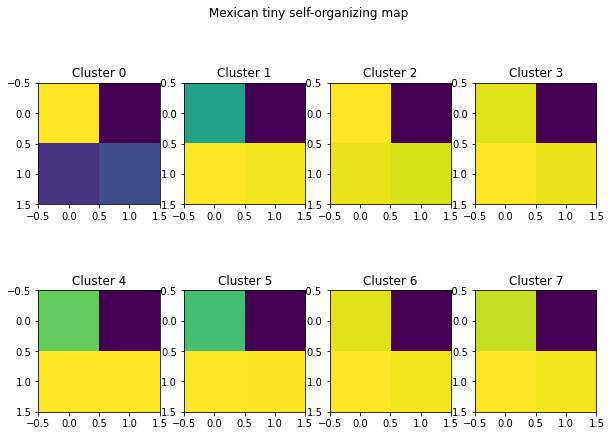

Mexican tiny v-measure: 0.2766287277342472
Mexican small:


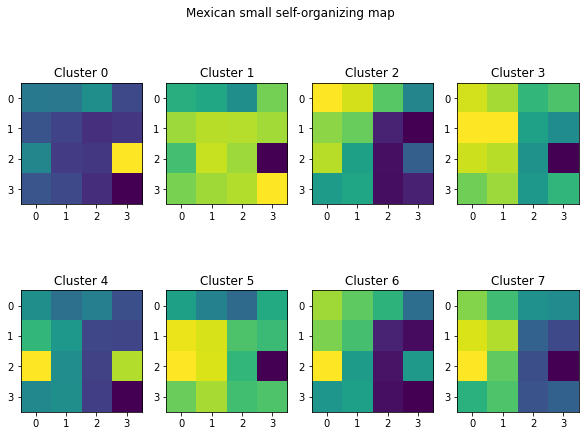

Mexican small v-measure: 0.5693368250806524
Mexican medium:


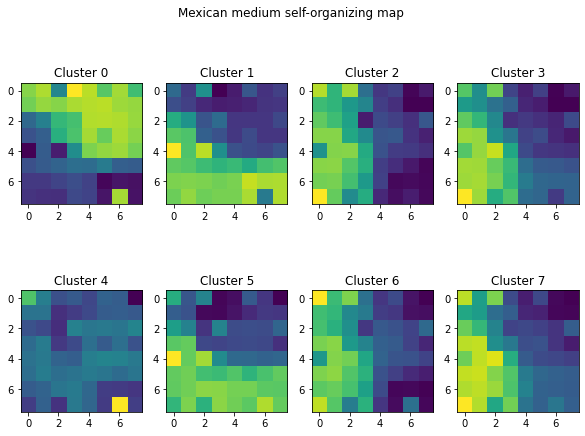

Mexican medium v-measure: 0.6413015497024
Mexican large:


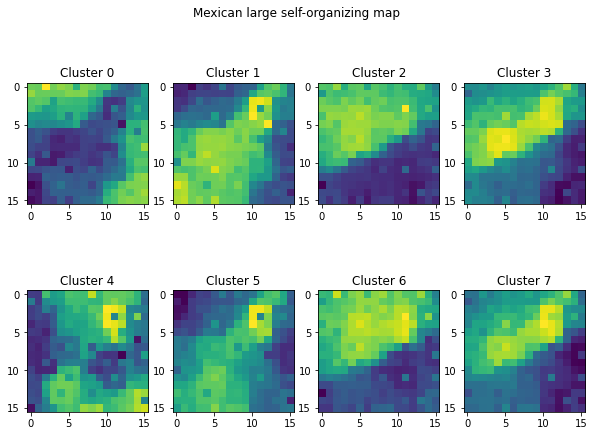

Mexican large v-measure: 0.5585867885100178


In [113]:
n_set = zip(["Gauss", "Mexican"], [gauss_factory, mexican_factory_no_t])
for n_name, n_factory in n_set:
    sizes_set = zip(
        ["tiny", "small", "medium", "large"],
        [(2,2),  (4,4),   (8,8),    (16,16)]
    )
    for size_name, size in sizes_set:
        print(f"{n_name} {size_name}:")
        cubkoh = KOH(
            data_cub,
            size,
            neighborhood = n_factory(distance_euclidean),
            slowdown_function = exp_slowdown_factory(0.1),
            evaluation_data = split_cub
        )
        run_test_suite_cube(
            cubkoh,
            50,
            f"{n_name} {size_name}"
        )

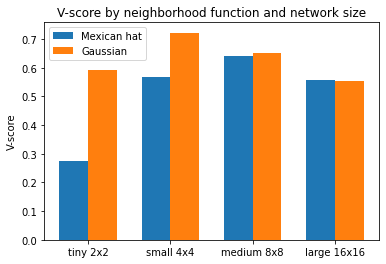

In [114]:
labels = ['tiny 2x2', 'small 4x4', 'medium 8x8', 'large 16x16']
mexican_means = [res for name, res in v_measures_cube.items() if name[0] == "M"]
gauss_means = [res for name, res in v_measures_cube.items() if name[0] == "G"]

x = np.arange(len(labels))
width = 0.35 

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mexican_means, width, label='Mexican hat')
rects2 = ax.bar(x + width/2, gauss_means, width, label='Gaussian')

ax.set_ylabel('V-score')
ax.set_title('V-score by neighborhood function and network size')
ax.set_xticks(x, labels)
ax.legend()

plt.show()

Tym razem gaussowska funkcja sąsiedzctwa działa lepiej. Niestety dosyć długo się wykonuje, więc nie będę drążył tematu. Prawdopodobnie będę musiał zwektoryzować algorytm, żeby móc przygotować następny checkpoint.